# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 0. Подключение библиотек

In [34]:
import pandas as pd
from textwrap import dedent
from IPython import get_ipython
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Шаг 1. Откройте файл с данными и изучите общую информацию. 


* Сперва загрузим файл и отобразим 5 строк

In [35]:
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('D:\DDownloads/real_estate_data.csv', sep='\t')

In [36]:
df.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
234,3,7820000.0,57.0,2019-04-18T00:00:00,2,NaN,5.0,33.0,3,NaN,...,8.0,NaN,Санкт-Петербург,26852.0,5700.0,2.0,586.0,0.0,NaN,NaN
22754,9,4400000.0,54.0,2016-04-04T00:00:00,3,2.50,5.0,37.0,5,NaN,...,7.0,1.0,Санкт-Петербург,35408.0,10469.0,0.0,NaN,1.0,496.0,218.0
8002,6,900000.0,30.3,2016-08-25T00:00:00,1,2.50,5.0,17.5,3,NaN,...,4.9,1.0,деревня Белогорка,NaN,NaN,NaN,NaN,NaN,NaN,630.0
20150,7,6990000.0,86.0,2018-02-01T00:00:00,3,2.76,16.0,44.7,1,NaN,...,14.7,NaN,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,435.0
591,7,4300000.0,44.0,2017-11-08T00:00:00,2,NaN,5.0,28.3,2,NaN,...,5.9,1.0,Санкт-Петербург,15674.0,8555.0,1.0,494.0,0.0,NaN,35.0
10104,11,6200000.0,46.0,2018-02-01T00:00:00,1,2.80,11.0,NaN,2,NaN,...,NaN,NaN,Санкт-Петербург,13789.0,8936.0,1.0,505.0,1.0,1172.0,52.0
16648,7,2400000.0,34.0,2019-03-14T00:00:00,1,2.55,12.0,16.0,1,NaN,...,7.1,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,26.0
13697,8,2855000.0,45.4,2018-03-01T00:00:00,1,NaN,6.0,18.6,3,NaN,...,12.0,NaN,Отрадное,NaN,NaN,NaN,NaN,NaN,NaN,254.0
2169,1,14000000.0,117.1,2019-02-22T00:00:00,4,3.52,5.0,82.4,3,NaN,...,10.3,NaN,Санкт-Петербург,23401.0,4183.0,0.0,NaN,0.0,NaN,NaN
20551,9,3200000.0,35.4,2018-03-06T00:00:00,1,NaN,20.0,15.5,10,NaN,...,9.0,NaN,деревня Новое Девяткино,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

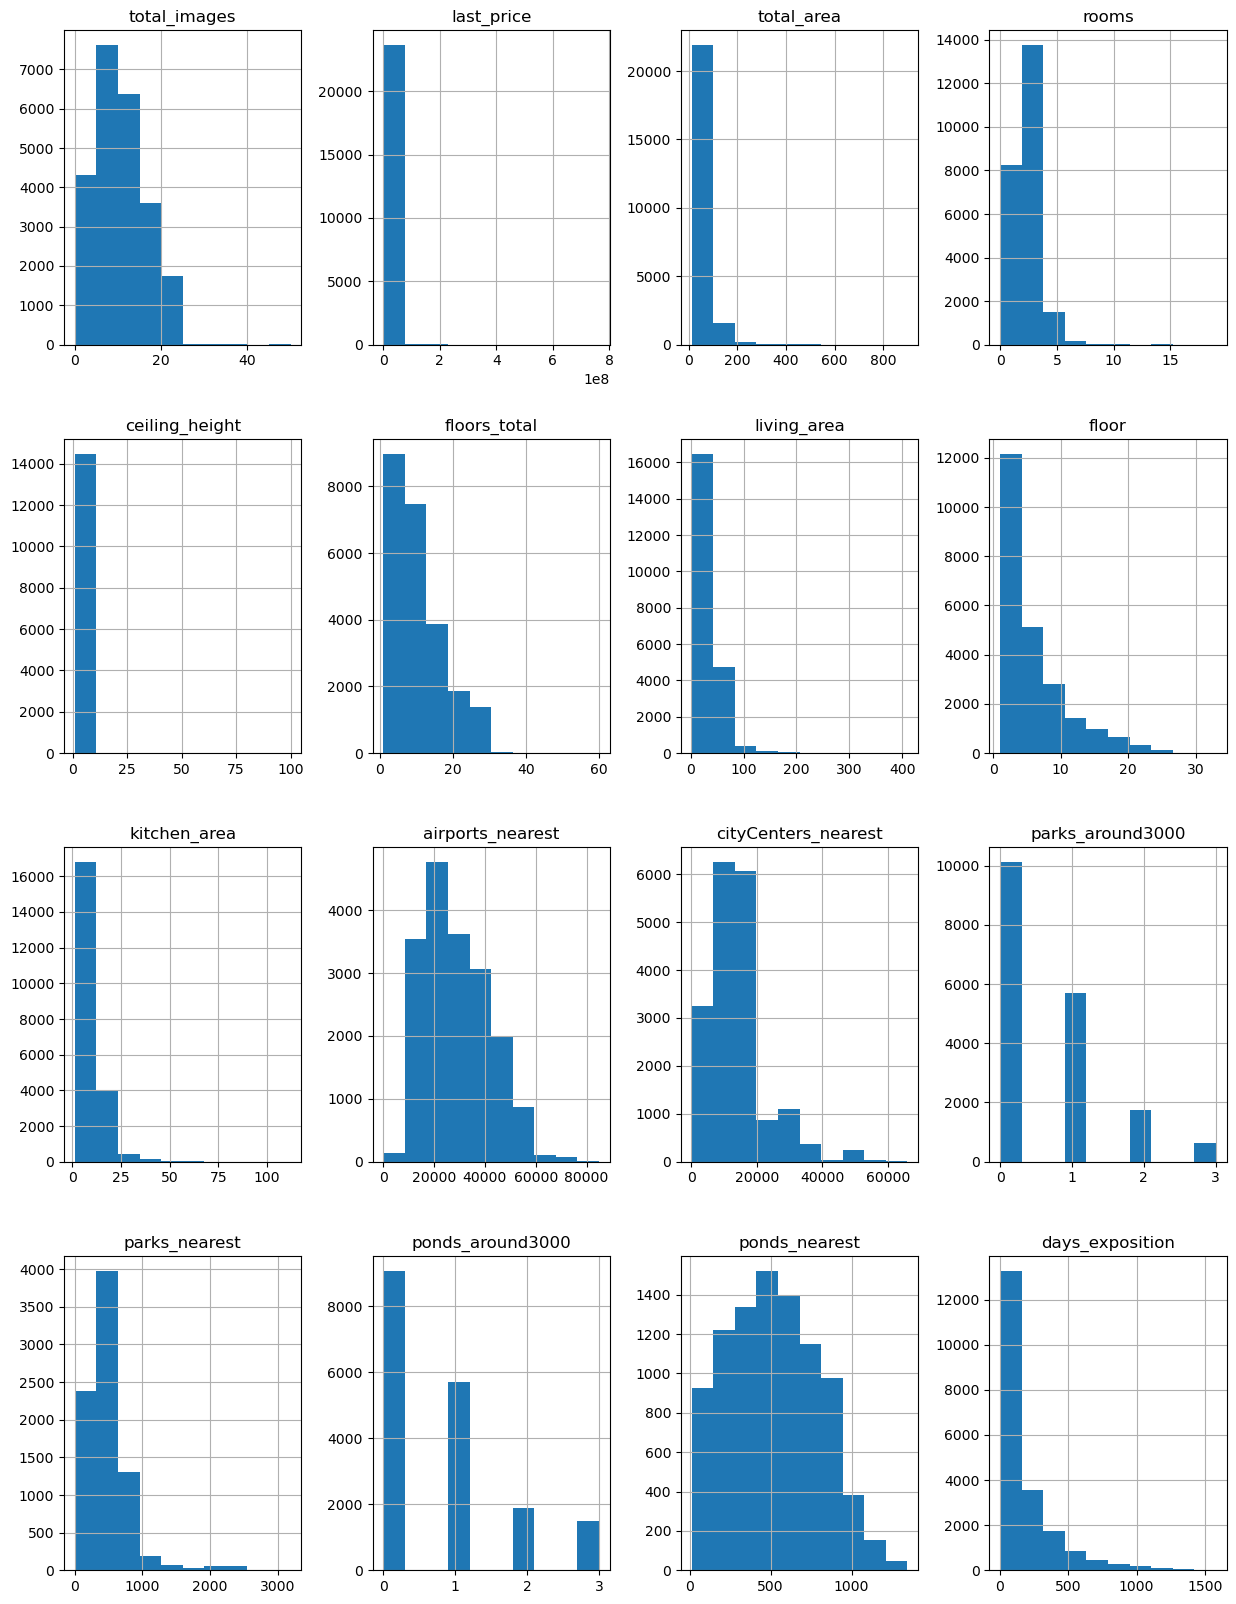

In [38]:
#выбираем числовые столбцы для гистограммы
cols = ['total_images', 'last_price', 'total_area', 'rooms', 'ceiling_height', 
        'floors_total', 'living_area', 'floor', 'kitchen_area', 'airports_nearest', 
        'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 
        'ponds_nearest', 'days_exposition']
#выводим на экран
df[cols].hist(figsize=(15,20))
plt.show()

### Предобработка данных

In [39]:
def investigate_column(column):
    print('Null or Na count is', column.isna().sum())
    print(column.describe())

In [40]:
#Оборачиваем график в функцию для дальнейшего использования.
def buildHist(data, xname, title):
    plt.figure(figsize=(10,3))
    data.hist()
    plt.xlabel(xname)
    plt.title(title)
    plt.ticklabel_format(style='plain') # убираем scientific notation
    plt.show()


#### 1. Обработка "total_images"


* Изучим значения


In [41]:
investigate_column(df["total_images"])

Null or Na count is 0
count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64



* Вывод
	- Обнаруженные аномалии: ...
	- Причины, по которым они могли возникнуть: ...
	- Как исправлять: ...
	- Финальный тип и почему: ...


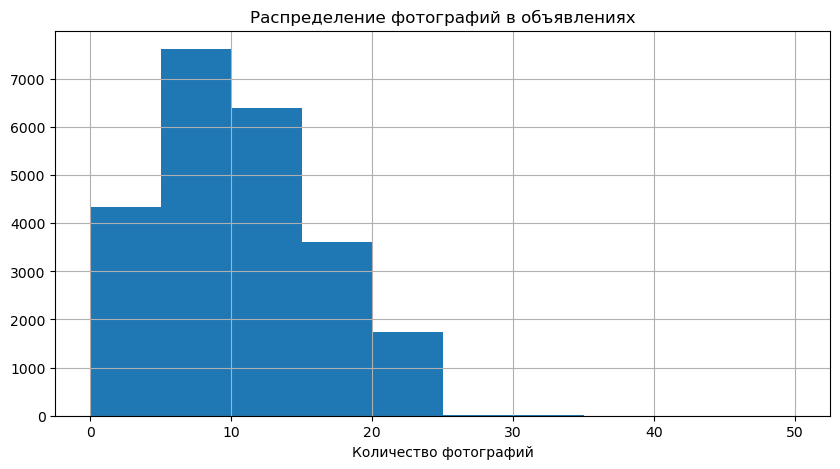

In [42]:
# выводим график
df["total_images"].hist(figsize=(10,5))
plt.xlabel('Количество фотографий')
plt.title('Распределение фотографий в объявлениях')
plt.show() 

На графике видим, что в больлинстве объявлений около 10 фотографий


#### 2. Обработка "last_price"




* Изучим значения


In [43]:
investigate_column(df["last_price"])

Null or Na count is 0
count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64



* Вывод
	- Обнаруженные аномалии: некорректо отображается цена
	- Причины, по которым они могли возникнуть: 
	- Как исправлять: ...
	- Финальный тип и почему: ...



#### 3. Обработка "total_area"



* Изучим значения


In [44]:
investigate_column(df["total_area"])

Null or Na count is 0
count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


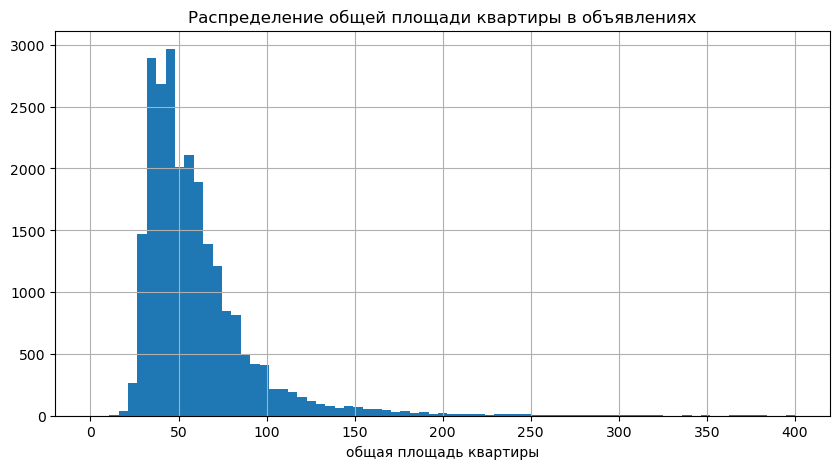

In [45]:
#buildHist(df.total_area, xname='Количество', title='Распределение')
df["total_area"].hist(figsize=(10,5), bins=75, range=(0, 400))
plt.xlabel('общая площадь квартиры')
plt.title('Распределение общей площади квартиры в объявлениях')
plt.show() 


* Вывод
	- Обнаруженные аномалии: нет
	- Причины, по которым они могли возникнуть: нет
	- Как исправлять: данные в норме
	- Финальный тип и почему: ...



#### 4. Обработка "first_day_exposition"



* Изучим значения


In [46]:
investigate_column(df["first_day_exposition"])

Null or Na count is 0
count                   23699
unique                   1491
top       2018-02-01T00:00:00
freq                      368
Name: first_day_exposition, dtype: object



* Вывод
	- Обнаруженные аномалии: тип данных object
	- Причины, по которым они могли возникнуть: ...
	- Как исправлять: перевести datetime
	- Финальный тип и почему: ...


In [47]:
#Изменение, методом to_datetime в datetime64
df['first_day_datetime'] = pd.to_datetime(df['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
df['first_day_datetime'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_datetime, dtype: datetime64[ns]

проверям наш датасет, оригинальную колонку решил оставить, мб пригодиться потом для проверки

In [48]:

df.sample(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,first_day_datetime
12197,17,5200000.0,90.6,2016-03-18T00:00:00,3,2.7,6.0,56.0,6,NaN,...,0.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,196.0,2016-03-18
16111,18,3355000.0,38.0,2017-11-20T00:00:00,1,NaN,17.0,13.0,12,NaN,...,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,64.0,2017-11-20
10430,8,2900000.0,41.2,2018-03-06T00:00:00,1,3.0,18.0,17.0,18,NaN,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,74.0,2018-03-06


для удобства переместим колонку first_day_datetime рядом с first_day_exposition

In [49]:

first_day_datetime = df.pop('first_day_datetime')

In [50]:
df.insert(4, 'first_day_datetime', first_day_datetime)

In [51]:
df

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,2019-03-07,3,2.70,16.0,51.0,8,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,2018-12-04,1,NaN,11.0,18.6,1,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2015-08-20,2,NaN,5.0,34.3,4,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,2015-07-24,3,NaN,14.0,NaN,9,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2018-06-19,2,3.03,14.0,32.0,13,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,2017-03-21,3,3.70,5.0,73.3,3,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,2018-01-15,3,NaN,5.0,38.0,4,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2018-02-11,2,NaN,3.0,29.7,1,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2017-03-28,2,3.00,17.0,NaN,12,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0



#### 5. Обработка "rooms"



* Изучим значения


In [52]:
investigate_column(df["rooms"])

Null or Na count is 0
count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64



* Вывод
	- Обнаруженные аномалии: минимальное значение 0, число комнат не может быть равна о, какая бы это квартира не была
	- Причины, по которым они могли возникнуть: пользователь забыл добавить или же в данных ошибка
	- Как исправлять: определим количество нулевы значений, и решим удалим или нет
	- Финальный тип и почему: перевести в инт32



* Изменение


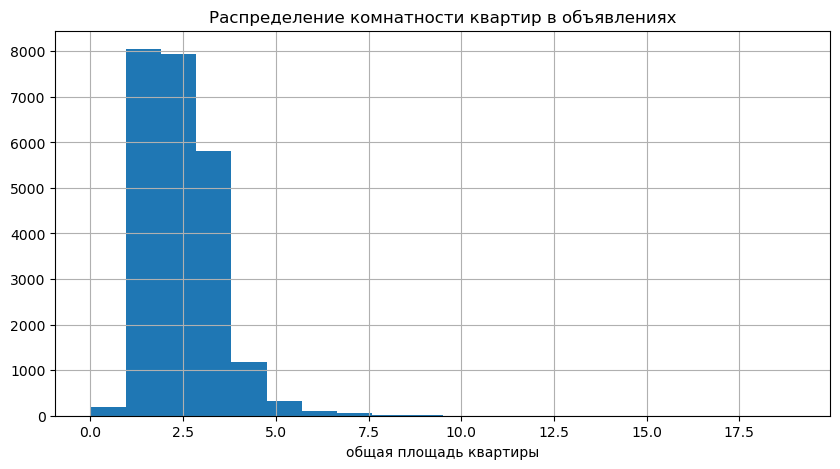

In [53]:
df["rooms"].hist(figsize=(10,5), bins=20)
plt.xlabel('общая площадь квартиры')
plt.title('Распределение комнатности квартир в объявлениях')
plt.show() 

на графике видим, что в основном в объявлених 2-3х комнатные квартиры, но так же настараживает нулевые значения

In [54]:
(df['rooms']==0).sum()

197

In [55]:
df[df['rooms']==0].sample(5)

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
17824,10,2300000.0,22.5,2017-09-27T00:00:00,2017-09-27,0,NaN,22.0,20.0,7,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,11.0
4115,7,2600000.0,24.0,2018-02-01T00:00:00,2018-02-01,0,NaN,25.0,18.0,4,...,NaN,2.0,Санкт-Петербург,10031.0,13330.0,1.0,915.0,0.0,NaN,42.0
8408,7,1599000.0,27.0,2019-03-19T00:00:00,2019-03-19,0,NaN,3.0,19.0,2,...,NaN,NaN,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19697,17,4200000.0,24.6,2018-03-15T00:00:00,2018-03-15,0,2.75,16.0,18.9,9,...,NaN,2.0,Санкт-Петербург,34201.0,14069.0,0.0,NaN,0.0,NaN,75.0
10720,9,2700000.0,24.0,2017-05-18T00:00:00,2017-05-18,0,NaN,25.0,16.0,6,...,NaN,2.0,Санкт-Петербург,42901.0,9267.0,0.0,NaN,0.0,NaN,6.0


смотрим в каких строках есть пропуски, возможно есть какая то связь

In [56]:
df = df[df['rooms']!=0]

- 197 нулевых значений, что меньше 1%, можно удалить
- перезапишем датасет с помощью булевой индексикацией

In [57]:
(df['rooms']==0).sum()

0

In [58]:
# Изменение столбца на целочисленное
df["rooms"] = df["rooms"].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23502 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23502 non-null  int64         
 1   last_price            23502 non-null  float64       
 2   total_area            23502 non-null  float64       
 3   first_day_exposition  23502 non-null  object        
 4   first_day_datetime    23502 non-null  datetime64[ns]
 5   rooms                 23502 non-null  int32         
 6   ceiling_height        14422 non-null  float64       
 7   floors_total          23419 non-null  float64       
 8   living_area           21613 non-null  float64       
 9   floor                 23502 non-null  int64         
 10  is_apartment          2769 non-null   object        
 11  studio                23502 non-null  bool          
 12  open_plan             23502 non-null  bool          
 13  kitchen_area    

C:\Users\User\AppData\Local\Temp\ipykernel_7564\1680839446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rooms"] = df["rooms"].astype('int32')



#### 6. Обработка "ceiling_height"



* Изучим значения


In [59]:
investigate_column(df["ceiling_height"])

Null or Na count is 9080
count    14422.000000
mean         2.769607
std          1.248101
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64



* Вывод
	- Обнаруженные аномалии: минимум - 1, максимум - 100
	- Причины, по которым они могли возникнуть: человеческий фактор,опечатки, ошибки в данных
	- Как исправлять: удалить слишком маленькие(<2) и большие(>4) значения
	- Финальный тип и почему: ...


сначала посмотрим на все уникальные значения

In [60]:
sorted(df["ceiling_height"].unique())

[1.0,
 2.0,
 2.3,
 2.4,
 2.45,
 2.46,
 2.48,
 2.53,
 2.59,
 2.62,
 2.63,
 2.7,
 nan,
 1.2,
 1.75,
 2.2,
 2.25,
 2.34,
 2.47,
 2.49,
 2.5,
 2.51,
 2.52,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.6,
 2.61,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,


для значений больше 20, моя теория в том что пользователь добавил лишний нолик

принимаю решение переставить точку где значение >20

In [61]:
df.loc[df['ceiling_height'] >= 20, 'ceiling_height'] /= 10
sorted(df["ceiling_height"].unique())

[1.0,
 1.2,
 1.75,
 2.0,
 2.2,
 2.25,
 2.2600000000000002,
 2.7,
 nan,
 2.3,
 2.34,
 2.4,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.52,
 2.53,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.59,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,

теперь для значений больше 4, решаю заполинть медианой, значений меньше 4

In [62]:
df['ceiling_height'].median()

2.65

In [63]:
median_ceiling_height = df.loc[df['ceiling_height'] < 4, 'ceiling_height'].median()
median_ceiling_height

2.65

заменяем значений больше 4м на медиану, и выводим на экран уникальные значения

In [64]:
df.loc[df['ceiling_height'] > 4, 'ceiling_height'] = median_ceiling_height
sorted(df["ceiling_height"].unique())

[1.0,
 2.0,
 2.3,
 2.4,
 2.45,
 2.46,
 2.52,
 2.53,
 2.58,
 2.59,
 2.66,
 2.7,
 nan,
 1.2,
 1.75,
 2.2,
 2.25,
 2.2600000000000002,
 2.34,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.54,
 2.55,
 2.56,
 2.57,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,

In [65]:
df["ceiling_height"].value_counts(dropna=False)

NaN     9080
2.50    3520
2.60    1638
2.70    1559
3.00    1109
        ... 
3.98       1
3.83       1
3.87       1
3.44       1
3.59       1
Name: ceiling_height, Length: 149, dtype: int64

In [66]:
#количество строк где ceiling_height меньше 2
(df['ceiling_height'] < 2).sum()
df[df['ceiling_height'] < 2]

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000.0,42.8,2017-08-14T00:00:00,2017-08-14,2,1.20,2.0,27.5,1,...,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000.0,40.0,2017-10-17T00:00:00,2017-10-17,1,1.75,37.0,17.4,5,...,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
22590,16,6000000.0,55.0,2018-10-31T00:00:00,2018-10-31,2,1.00,12.0,32.4,7,...,10.00,NaN,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


всего три строки, оставим как есть
-итог: очистили колонку от аномально больших значений, где больше 20м переставили точку, где больше 4м заменили на медиану 2,65


#### 7. Обработка "floors_total"



* Изучим значения


In [67]:
investigate_column(df["floors_total"])

Null or Na count is 83
count    23419.000000
mean        10.622273
std          6.569964
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64



* Вывод
	- Обнаруженные аномалии: максимальное значение 60(!) этажей
	- Причины, по которым они могли возникнуть: чел. фактор
	- Как исправлять: заменить 60 на 6
	- Финальный тип и почему: с float64 перейти на инт32


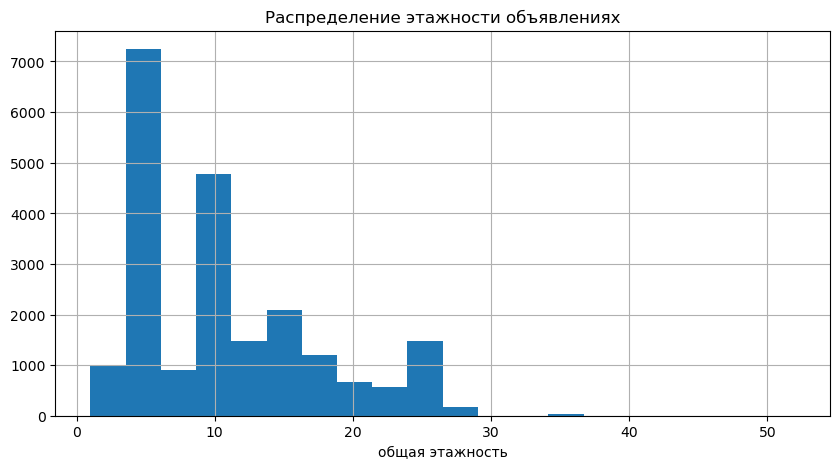

In [182]:
df["floors_total"].hist(figsize=(10,5), bins=20)
plt.xlabel('общая этажность')
plt.title('Распределение этажности объявлениях')
plt.show() 

- По графику видим что в основном этажность до 10
- пропусков 86 из 23613, это меньше пол процента, так что можно их удалить

In [69]:
# удаляем пропуски
df = df.dropna(subset=['floors_total'])
#df['floors_total'].isna().sum()
df[df["floors_total"]==0]

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [70]:
#вычесляем аномальное значение  больше 40
df[df['floors_total'] > 40].head()

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000.0,45.5,2018-06-28T00:00:00,2018-06-28,2,2.88,60.0,27.4,4,...,7.4,NaN,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
16731,9,3978000.0,40.0,2018-09-24T00:00:00,2018-09-24,1,2.65,52.0,10.5,18,...,14.0,NaN,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


врядли в Кронштадт есть 60 этажка, заменим на 6

In [71]:
#замена аномальных значений
df.loc[df['floors_total'] == 60, 'floors_total'] /= 10
df[df['floors_total'] > 40].head()

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
16731,9,3978000.0,40.0,2018-09-24T00:00:00,2018-09-24,1,2.65,52.0,10.5,18,...,14.0,NaN,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


In [72]:
#проверяем ушла ли 60 этажка
df.floors_total.describe()

count    23419.000000
mean        10.619967
std          6.562105
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         52.000000
Name: floors_total, dtype: float64

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23419 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23419 non-null  int64         
 1   last_price            23419 non-null  float64       
 2   total_area            23419 non-null  float64       
 3   first_day_exposition  23419 non-null  object        
 4   first_day_datetime    23419 non-null  datetime64[ns]
 5   rooms                 23419 non-null  int32         
 6   ceiling_height        14413 non-null  float64       
 7   floors_total          23419 non-null  float64       
 8   living_area           21560 non-null  float64       
 9   floor                 23419 non-null  int64         
 10  is_apartment          2769 non-null   object        
 11  studio                23419 non-null  bool          
 12  open_plan             23419 non-null  bool          
 13  kitchen_area    

In [74]:
# Изменение столбца на целочисленное
df["floors_total"] = df["floors_total"].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23419 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23419 non-null  int64         
 1   last_price            23419 non-null  float64       
 2   total_area            23419 non-null  float64       
 3   first_day_exposition  23419 non-null  object        
 4   first_day_datetime    23419 non-null  datetime64[ns]
 5   rooms                 23419 non-null  int32         
 6   ceiling_height        14413 non-null  float64       
 7   floors_total          23419 non-null  int32         
 8   living_area           21560 non-null  float64       
 9   floor                 23419 non-null  int64         
 10  is_apartment          2769 non-null   object        
 11  studio                23419 non-null  bool          
 12  open_plan             23419 non-null  bool          
 13  kitchen_area    


#### 8. Обработка "living_area"


* Изучим значения


In [75]:
investigate_column(df["living_area"])

Null or Na count is 1859
count    21560.000000
mean        34.595172
std         22.075463
min          2.000000
25%         18.700000
50%         30.000000
75%         42.500000
max        409.700000
Name: living_area, dtype: float64



* Вывод
	- Обнаруженные аномалии:  минимальное значение 2, 
	- Причины, по которым они могли возникнуть: возможно забыли добавить 0
	- Как исправлять: умножить на 10?
	- Финальный тип и почему: не могут быть жил. площадь равно 2м, нужно исправлять, 
        но надо посчитать сколбко таких минимальных значний и на сколько сильно они влияют на датасет
        пропуски 1870 это около 8%, что меньше 10% можно и удалить


In [76]:
# сначала удалим пропуски
df = df.dropna(subset=['living_area'])
df['floors_total'].isna().sum()

0

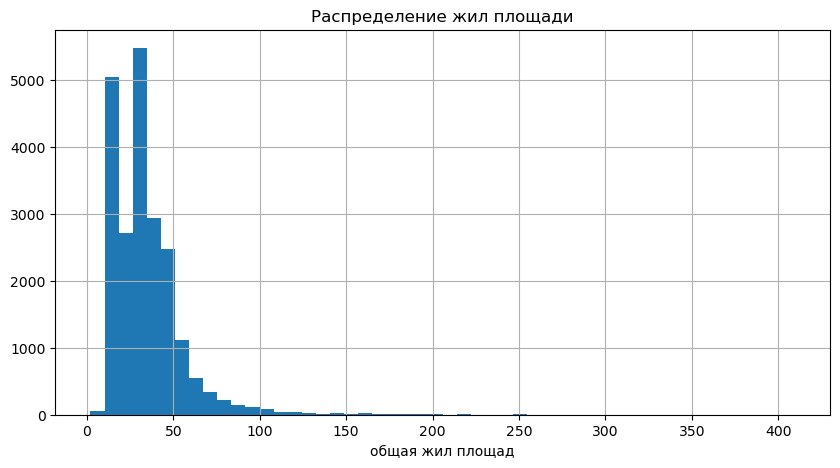

In [77]:
# постороение гистограммы распред. по жил площади
# df['living_area'].plot(kind='hist', bins=20, alpha=0.5,title='Распределение жил площади')
# plt.show()
df["living_area"].hist(figsize=(10,5), bins=50)
plt.xlabel('общая жил площад')
plt.title('Распределение жил площади')
plt.show() 

*Вижу что особого пика в данных нет, неудивительно что в основнов варируются около 50-100 м2

In [78]:
#количество строк где living_area меньше или 10
(df['living_area'] <= 10).sum()

53

In [79]:
#количество строк где living_area меньше 10 но больше или ровно 2 комнаты
((df['living_area'] <= 10)&(df['rooms'] >= 2)).sum()

9

In [80]:
df[df['living_area'] < 10].sample(5)

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
114,5,4000000.0,21.4,2019-02-07T00:00:00,2019-02-07,1,2.9,8,8.3,7,...,6.3,NaN,Санкт-Петербург,27089.0,5791.0,2.0,488.0,1.0,286.0,NaN
15833,20,4600000.0,33.0,2017-01-01T00:00:00,2017-01-01,1,2.7,22,9.0,12,...,14.3,1.0,Санкт-Петербург,33803.0,13671.0,0.0,NaN,0.0,NaN,511.0
23574,14,64990000.0,139.0,2015-11-24T00:00:00,2015-11-24,3,3.0,8,3.0,8,...,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0
21943,15,6100000.0,77.6,2019-02-28T00:00:00,2019-02-28,4,2.5,9,5.4,1,...,9.8,NaN,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0
8325,9,4800000.0,52.0,2017-10-25T00:00:00,2017-10-25,2,NaN,5,9.0,2,...,6.0,1.0,Санкт-Петербург,33358.0,13171.0,0.0,NaN,2.0,118.0,119.0


лучше оставим эти строки, так как по большому счету их мало и они не сильно влияют на датасет

#### 9. Обработка "floor"



* Изучим значения


In [81]:
investigate_column(df["floor"])

Null or Na count is 0
count    21560.000000
mean         5.853850
std          4.837603
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64



* Вывод
	- Обнаруженные аномалии: Аномалий нет
	- Причины, по которым они могли возникнуть: ...
	- Как исправлять: ...
	- Финальный тип и почему: лучше изменить тип на int32, так как не может быть 6,5 этажей


In [82]:
# Изменение столбца на целочисленное
df["floor"] = df["floor"].astype('int32')


#### 10. Обработка "is_apartment"



* Изучим значения


In [83]:
investigate_column(df["is_apartment"])

Null or Na count is 18911
count      2649
unique        2
top       False
freq       2607
Name: is_apartment, dtype: object



* Вывод
	- Обнаруженные аномалии: в таблице в основном пропуски, таблица заполнена на 13% булевыми значениями,
	- Причины, по которым они могли возникнуть: не всегда пользователь заполняет все значения
	- Как исправлять: оставим все как есть
	- Финальный тип и почему: ...



#### 11. Обработка "studio"



* Изучим значения


In [84]:
investigate_column(df["studio"])

Null or Na count is 0
count     21560
unique        2
top       False
freq      21549
Name: studio, dtype: object



* Вывод
	- Обнаруженные аномалии: нет
	- Причины, по которым они могли возникнуть: ...
	- Как исправлять: ...
	- Финальный тип и почему: ...



#### 12. Обработка "open_plan"



* Изучим значения


In [85]:
investigate_column(df["open_plan"])

Null or Na count is 0
count     21560
unique        2
top       False
freq      21553
Name: open_plan, dtype: object



* Вывод
	- Обнаруженные аномалии: нет
	- Причины, по которым они могли возникнуть: ...
	- Как исправлять: ...
	- Финальный тип и почему: ...



* Изменение



#### 13. Обработка "kitchen_area"



* Изучим значения


In [86]:
investigate_column(df["kitchen_area"])

Null or Na count is 617
count    20943.000000
mean        10.511091
std          5.842044
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64



* Вывод
	- Обнаруженные аномалии: 812 пропусков, с учетом ранее удаленных столбцов пропуски составляют около 13%, так что в 
        этот раз не будим удалять данные
	- Причины, по которым они могли возникнуть: возможно это коммерческий тип
	- Как исправлять: если исправим на 0, то это сильно исказить среднее и медиану, лучше оставим как есть
	- Финальный тип и почему: ...



#### 14. Обработка "balcony"



* Изучим значения


In [87]:
investigate_column(df["balcony"])

Null or Na count is 10030
count    11530.000000
mean         1.147008
std          1.067170
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64



* Вывод
	- Обнаруженные аномалии: пропуски около 50%
	- Причины, по которым они могли возникнуть: скорее всего там где нет данных это говорит об их отсутствии болконов
	- Как исправлять: пропуски заменим на 0
	- Финальный тип и почему: ...


In [88]:
df['balcony'].fillna(0, inplace=True)

In [89]:
# Изменение столбца на целочисленное
df["balcony"] = df["balcony"].astype('int32')


#### 15. Обработка "locality_name"



* Изучим значения


In [90]:
investigate_column(df["locality_name"])

Null or Na count is 43
count               21517
unique                347
top       Санкт-Петербург
freq                14431
Name: locality_name, dtype: object



* Вывод
	- Обнаруженные аномалии: 348 уникальных значений, хотя датасет основан на данных в питере и в соседних населенных пунктах
	- Причины, по которым они могли возникнуть: дублирование названий городов
	- Как исправлять: удалим повторяющиеся значения такие как поселок, деревня, село и тд, 43 пропущенных значений
        , можно и удалить но я лучше заменю на 'unknown'
	- Финальный тип и почему: ...


In [91]:
df["locality_name"].unique()
len(df["locality_name"].unique())

348

удаляем название поселок, деревня и тд.

In [92]:
names_to_remove = {'деревня ': '', 'поселок ': '', 'посёлок ': '', 'поселок городского типа ': '', 'городского типа ': '',
                   'городской посёлок': '', 'коттеджный посёлок': '', 'посёлок при железнодорожной станции': '',
                   'посёлок станции': ''}
df['locality_name'] = df['locality_name'].replace(names_to_remove, regex=True)
len(df.locality_name.unique())

305

после всех манипуляций число уникю значений уменьшилось до 306, успех)

In [93]:
#вызываем функцию чтобы узнать сколько пропусков
investigate_column(df["locality_name"])

Null or Na count is 43
count               21517
unique                304
top       Санкт-Петербург
freq                14431
Name: locality_name, dtype: object


In [94]:
# пропуски заполним на unknown
df['locality_name'].fillna('unknown', inplace=True)


#### 16. Обработка "airports_nearest"



* Изучим значения


In [95]:
investigate_column(df["airports_nearest"])

Null or Na count is 4840
count    16720.000000
mean     28789.940251
std      12645.631640
min          0.000000
25%      18545.000000
50%      26710.000000
75%      37227.250000
max      84869.000000
Name: airports_nearest, dtype: float64


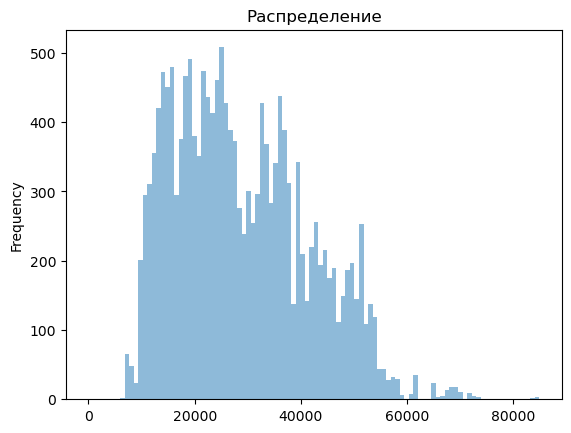

In [96]:
# постороение гистограммы распред. 
df['airports_nearest'].plot(kind='hist', bins=100, alpha=0.5,title='Распределение')
plt.show()

In [97]:
(df['airports_nearest']==0).sum()

1


* Вывод
	- Обнаруженные аномалии: есть 1 нулевое значение, но оно не сильно вляет на датасет в целом
        *5542 пропусков, но их не будим заменять на 0, так как это сильно исказит данные, 
	- Причины, по которым они могли возникнуть: забыли указать или же аэропорт слишком долеко (свыше 9км)
	- Как исправлять: лучше оставить как есть
	- Финальный тип и почему: ...



#### 17. Обработка "cityCenters_nearest"



* Изучим значения


In [98]:
investigate_column(df["cityCenters_nearest"])

Null or Na count is 4819
count    16741.000000
mean     14235.945583
std       8688.436994
min        181.000000
25%       9289.000000
50%      13095.000000
75%      16268.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


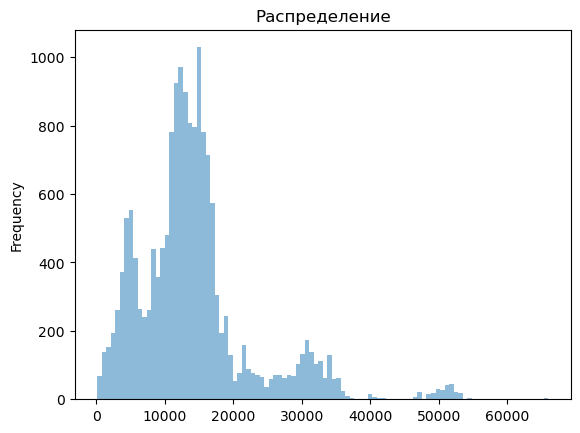

In [99]:
# постороение гистограммы распред. 
df['cityCenters_nearest'].plot(kind='hist', bins=100, alpha=0.5,title='Распределение')
plt.show()


* Вывод
	- Обнаруженные аномалии: около 20% пропусков, удалят это мы не будим
	- Причины, по которым они могли возникнуть: забыли указать или же центр города слишком далеко или объект находится не в городе
	- Как исправлять: лучше оставим как есть
	- Финальный тип и почему: ...



#### 18. Обработка "parks_around3000"



* Изучим значения


In [100]:
investigate_column(df["parks_around3000"])


Null or Na count is 4818
count    16742.000000
mean         0.612531
std          0.801986
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64


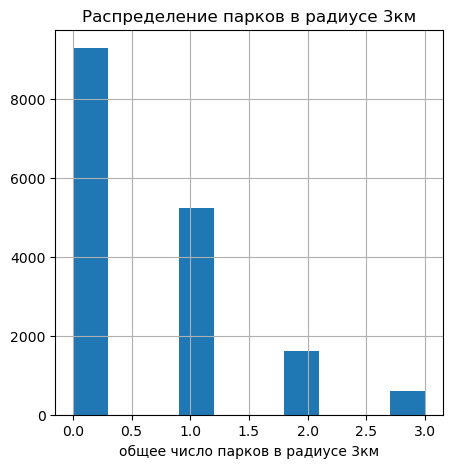

In [101]:
df["parks_around3000"].hist(figsize=(5,5), bins=10)
plt.xlabel('общее число парков в радиусе 3км')
plt.title('Распределение парков в радиусе 3км')
plt.show() 



* Вывод
	- Обнаруженные аномалии: 5518 пропусков
	- Причины, по которым они могли возникнуть: пользователь забыл указать или же в радиусе 3 км нет парков 
	- Как исправлять: лучше оставим как есть
	- Финальный тип и почему: ...



#### 19. Обработка "parks_nearest"



* Изучим значения


In [102]:
investigate_column(df["parks_nearest"])

Null or Na count is 14105
count    7455.000000
mean      487.757210
std       338.033172
min         1.000000
25%       287.000000
50%       451.000000
75%       610.000000
max      3190.000000
Name: parks_nearest, dtype: float64


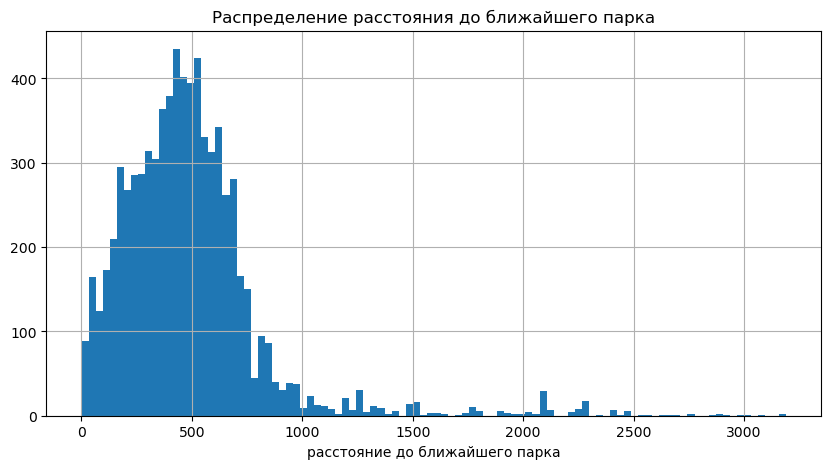

In [103]:
# постороение гистограммы распред. 
df["parks_nearest"].hist(figsize=(10,5), bins=100)
plt.xlabel('расстояние до ближайшего парка')
plt.title('Распределение расстояния до ближайшего парка')
plt.show() 


* Вывод
	- Обнаруженные аномалии: более 65% пропусков, минимальное значение 1м, что выглядит очень странно
	- Причины, по которым они могли возникнуть: ошибка пользователя или же в данных
	- Как исправлять: выяснить, сколько таких минимальных значений, и как сильно они портят всю картину
	- Финальный тип и почему: ...


In [104]:
#количество строк где расстояние до ближайшего парка меньше 5 м
(df["parks_nearest"] < 5).sum()


3

In [105]:
#количество строк где расстояние до ближайшего парка меньше 50 м
(df["parks_nearest"] < 50).sum()

173

как видим таких данных не так уж и много, оставим как есть


#### 20. Обработка "ponds_around3000"



* Изучим значения


In [106]:

investigate_column(df["ponds_around3000"])


Null or Na count is 4818
count    16742.000000
mean         0.765321
std          0.938174
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64


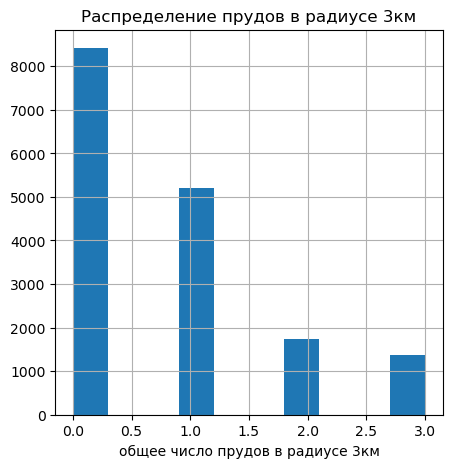

In [107]:
df["ponds_around3000"].hist(figsize=(5,5), bins=10)
plt.xlabel('общее число прудов в радиусе 3км')
plt.title('Распределение прудов в радиусе 3км')
plt.show() 

по графику видим что в основном нет прудов, либо есть 1-2


* Вывод
	- Обнаруженные аномалии: 20% пропусков
	- Причины, по которым они могли возникнуть: пользователь забыл указать или же в радиусе 3 км нет прудов 
	- Как исправлять: лучше оставить как есть
	- Финальный тип и почему: ...



#### 21. Обработка "ponds_nearest"



* Изучим значения


In [108]:
investigate_column(df["ponds_nearest"])

Null or Na count is 13238
count    8322.000000
mean      519.164263
std       277.251990
min        13.000000
25%       295.250000
50%       503.000000
75%       730.750000
max      1344.000000
Name: ponds_nearest, dtype: float64


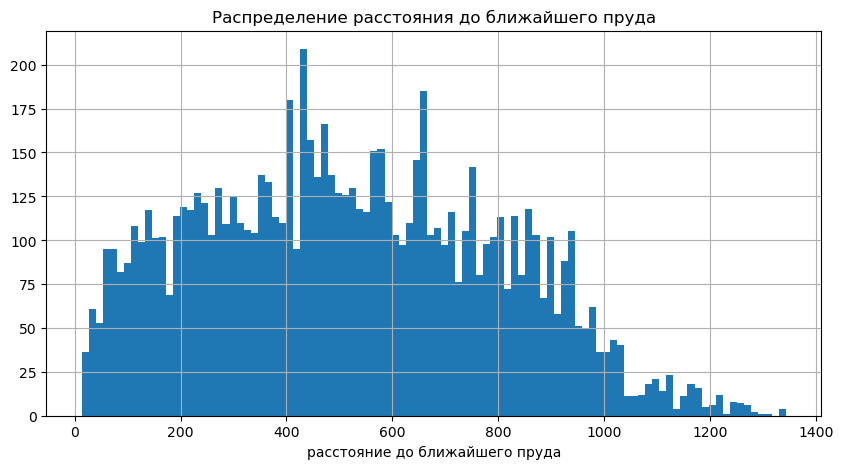

In [109]:
# постороение гистограммы распред. 
df["ponds_nearest"].hist(figsize=(10,5), bins=100)
plt.xlabel('расстояние до ближайшего пруда')
plt.title('Распределение расстояния до ближайшего пруда')
plt.show() 


* Вывод
	- Обнаруженные аномалии: 65% пропусков
	- Причины, по которым они могли возникнуть: вероятнее всего там нет прудов
	- Как исправлять: если заменим на 0, то это сильно исказит данные, оставим как есть
	- Финальный тип и почему: ...



#### 22. Обработка "days_exposition"



* Изучим значения


In [110]:
investigate_column(df["days_exposition"])

Null or Na count is 2965
count    18595.000000
mean       185.576230
std        221.684889
min          1.000000
25%         45.000000
50%        102.000000
75%        240.000000
max       1580.000000
Name: days_exposition, dtype: float64


In [111]:
#для удобства просмотра переместим столбец days_exposition ближе к началу
days_exposition = df.pop('days_exposition')
df.insert(5, 'days_exposition', days_exposition)
df.sample(3)

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,days_exposition,rooms,ceiling_height,floors_total,living_area,...,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
6232,6,2200000.0,33.0,2016-05-29T00:00:00,2016-05-29,44.0,1,2.75,5,18.0,...,False,11.0,2,Петергоф,45897.0,35511.0,0.0,NaN,1.0,640.0
9596,17,5650000.0,63.0,2018-02-08T00:00:00,2018-02-08,221.0,3,2.55,9,42.1,...,False,8.1,0,Санкт-Петербург,23139.0,12761.0,0.0,NaN,0.0,NaN
20213,20,14000000.0,102.0,2019-03-26T00:00:00,2019-03-26,NaN,3,3.80,5,55.4,...,False,11.8,1,Санкт-Петербург,20173.0,2779.0,3.0,346.0,1.0,727.0



* Вывод
	- Обнаруженные аномалии: пропусков больше 10%,
	- Причины, по которым они могли возникнуть: скорее всего пропуски там, где квартиры еще не продались, как видим сверху
        в объявлении 2019 года 
	- Как исправлять: оставим как есть
	- Финальный тип и почему: ...


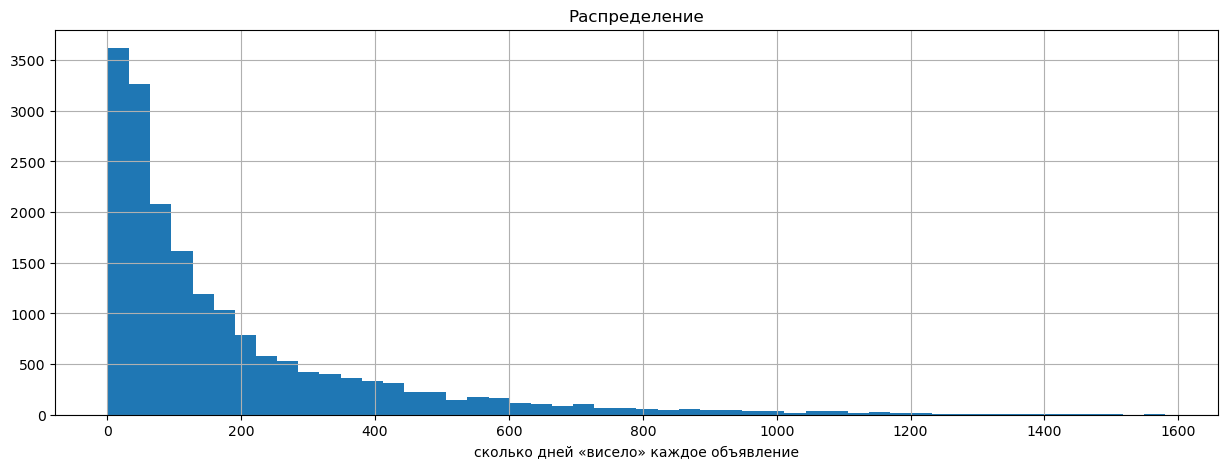

In [112]:
# постороение гистограммы распред. 
df["days_exposition"].hist(figsize=(15,5), bins=50)
plt.xlabel('сколько дней «висело» каждое объявление')
plt.title('Распределение')
plt.show() 

по графику видим что в основном продаются за 100 - 200 дней, замет идет заметное снижение

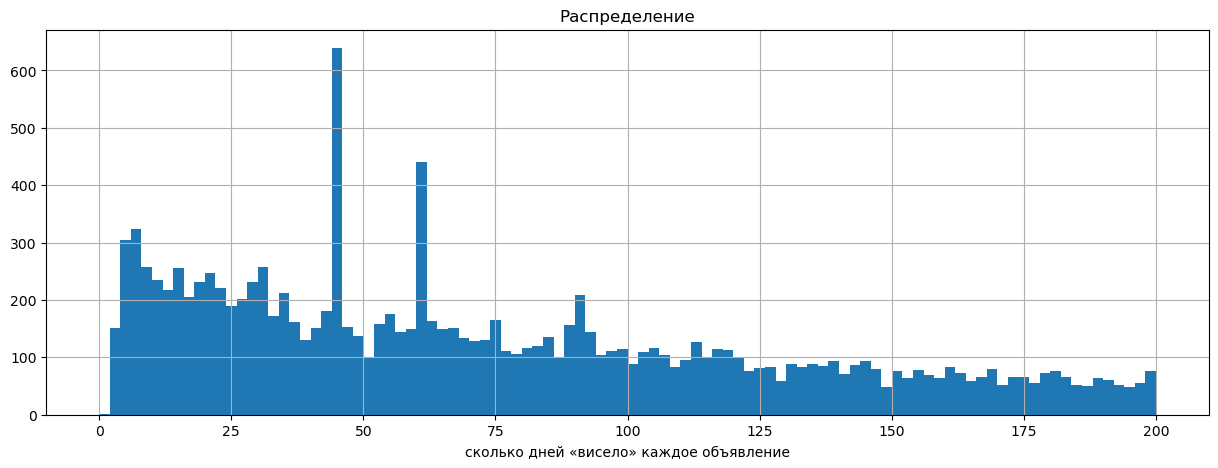

In [113]:
# в диапазоне 0, 200 
df["days_exposition"].hist(figsize=(15,5), bins=100, range=(0, 200))
plt.xlabel('сколько дней «висело» каждое объявление')
plt.title('Распределение')
plt.show() 

в этом диапазоне можно наблюдать аномальные пики в 45, 60 и 90 дней

In [114]:
#расчитываем медиану
df["days_exposition"].median()

102.0

In [115]:
#расчитываем среднее
df["days_exposition"].mean()

185.5762301694004

In [116]:
(df["days_exposition"] <=3).sum()
#df[df["days_exposition"] <7]

3

In [117]:
(df["days_exposition"] <=4).sum()

320

как видим особо быстрый продажей можно считать в течение 3 дня, всего таких сделок было 4

In [118]:
(df["days_exposition"] >= 1000).sum()

254

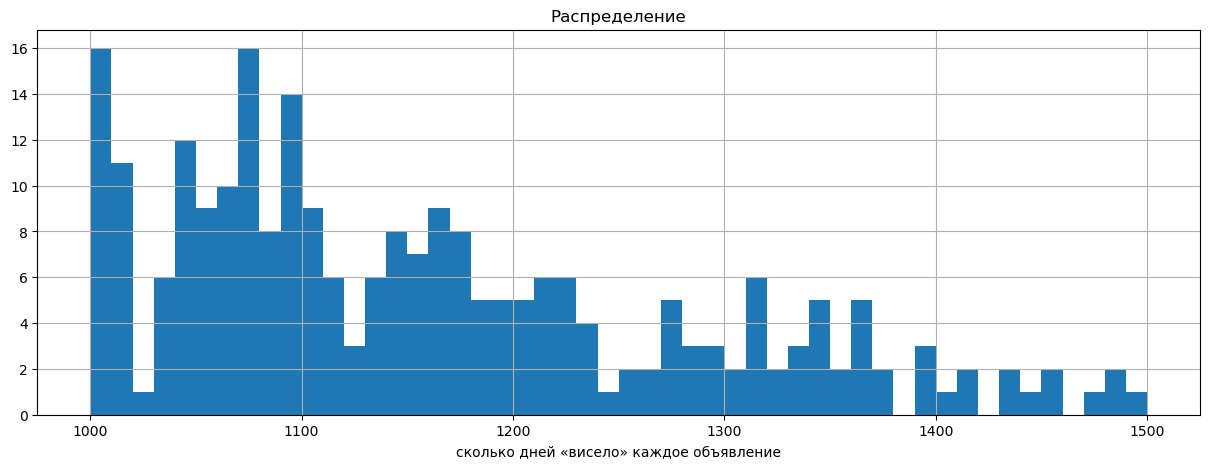

In [119]:
# в диапазоне 1000, 1500 
df["days_exposition"].hist(figsize=(15,5), bins=50, range=(1000, 1500))
plt.xlabel('сколько дней «висело» каждое объявление')
plt.title('Распределение')
plt.show() 

как видим по графику, к особо долгим можно отнести после 1200 дней

In [120]:
df.duplicated().sum()

0

### вывод по предобработке данных

Данные вполне сносные, если не считать про высоту потолков, где были явные аномальные значения до 100м. Были удаленые пропуски где в столбцах их меньше 10%, изменил на целочисленный формат в этажи, тотал этажи и балконы. столбец с датой преобразовал в datetime64, а старый object решил оставить на будущее, для проверки, и поставил по соседству.

### Посчитайте и добавьте в таблицу новые столбцы

In [121]:
#Цена кв. метра, делим цену на площадь и округляем
df['price_per_sqm'] = (df['last_price'] / df['total_area'] ).round(1)
df.sample(3)

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,days_exposition,rooms,ceiling_height,floors_total,living_area,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,price_per_sqm
14768,6,1850000.0,33.00,2017-01-23T00:00:00,2017-01-23,144.0,1,NaN,5,18.0,...,6.5,0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,56060.6
19236,12,5200000.0,52.05,2019-01-13T00:00:00,2019-01-13,NaN,3,2.5,9,35.4,...,6.7,2,Санкт-Петербург,43908.0,13488.0,1.0,606.0,0.0,NaN,99903.9
6994,11,4500000.0,106.20,2017-11-03T00:00:00,2017-11-03,242.0,5,NaN,5,67.5,...,8.5,0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,42372.9


In [122]:
#день публикации объявления 
df['weekday'] = df['first_day_datetime'].dt.weekday

In [123]:
#месяц публикации объявления
df['month'] = df['first_day_datetime'].dt.month

In [124]:
#год публикации объявления
df['year'] = df['first_day_datetime'].dt.year
df.sample(3)

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,days_exposition,rooms,ceiling_height,floors_total,living_area,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,price_per_sqm,weekday,month,year
17811,12,2830000.0,46.0,2018-02-01T00:00:00,2018-02-01,18.0,2,NaN,5,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,61521.7,3,2,2018
4814,6,5000000.0,43.0,2018-07-13T00:00:00,2018-07-13,182.0,3,3.0,5,24.0,...,24319.0,5233.0,1.0,439.0,0.0,NaN,116279.1,4,7,2018
11971,10,5000000.0,55.5,2017-10-31T00:00:00,2017-10-31,161.0,2,3.1,3,29.5,...,69715.0,51440.0,3.0,161.0,3.0,522.0,90090.1,1,10,2017


In [125]:
#тип этажа квартиры
#функция для определения
def floortype(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [126]:
#appy-им его на дф
df['floortype'] = df.apply(floortype, axis=1)

In [127]:
df.sample(3)

,total_images,last_price,total_area,first_day_exposition,first_day_datetime,days_exposition,rooms,ceiling_height,floors_total,living_area,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,price_per_sqm,weekday,month,year,floortype
3575,7,3680000.0,42.0,2017-10-31T00:00:00,2017-10-31,12.0,2,NaN,5,29.9,...,26676.0,0.0,NaN,0.0,NaN,87619.0,1,10,2017,другой
1490,18,3370000.0,50.5,2019-04-29T00:00:00,2019-04-29,NaN,2,2.55,5,27.5,...,NaN,NaN,NaN,NaN,NaN,66732.7,0,4,2019,последний
6955,0,3200000.0,42.0,2017-11-11T00:00:00,2017-11-11,82.0,1,NaN,8,19.0,...,30589.0,0.0,NaN,0.0,NaN,76190.5,5,11,2017,первый


In [128]:
#расстояние в км до центра города
#сначала делим на 1000 и прeминяем лямбда функцию где округляем не нулевые значения
df['cityCenters_nearest_km'] = (df['cityCenters_nearest'] / 1000).apply(lambda x: round(x) if pd.notnull(x) else x).astype('Int64') 

In [129]:
df['cityCenters_nearest_km']

0          16
1          19
2          14
4           8
5        <NA>
         ... 
23693      34
23694       4
23695    <NA>
23696    <NA>
23698    <NA>
Name: cityCenters_nearest_km, Length: 21560, dtype: Int64

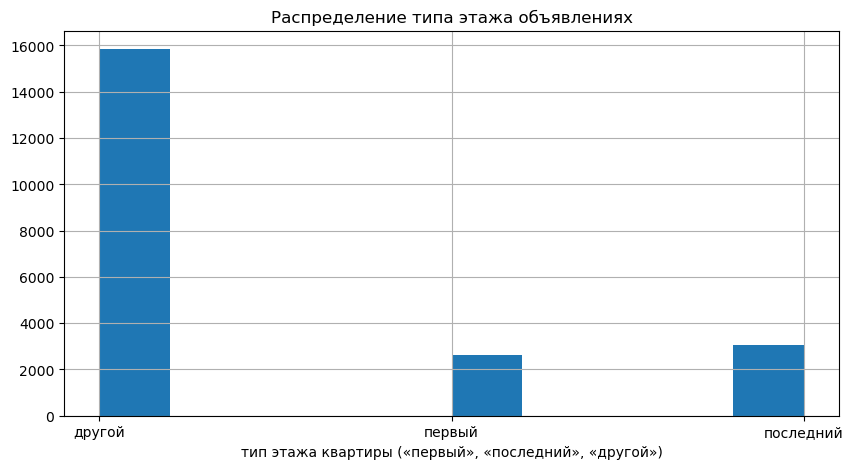

In [130]:
df["floortype"].hist(figsize=(10,5), bins=10)
plt.xlabel('тип этажа квартиры («первый», «последний», «другой»)')
plt.title('Распределение типа этажа объявлениях')
plt.show() 

как видим по графику, в основном в продаже квартиры тип этажности "Другие"

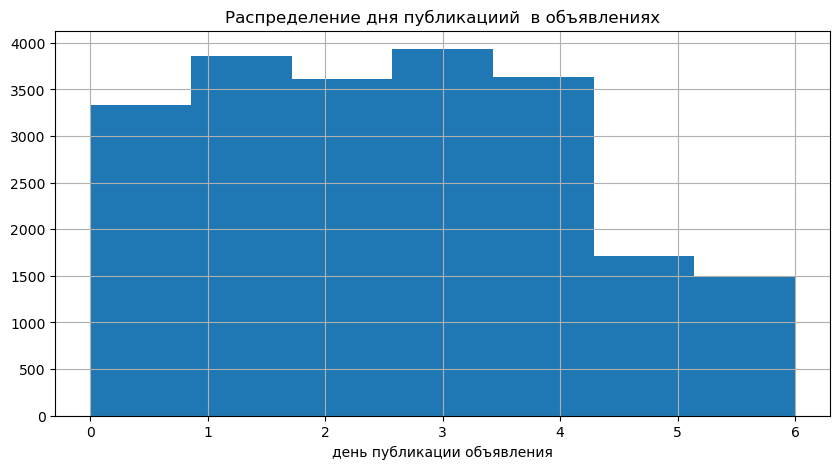

In [184]:
# день и месяц публикации объявления
df["weekday"].hist(figsize=(10,5), bins=7)
plt.xlabel('день публикации объявления')
plt.title('Распределение дня публикациий  в объявлениях')
plt.show() 

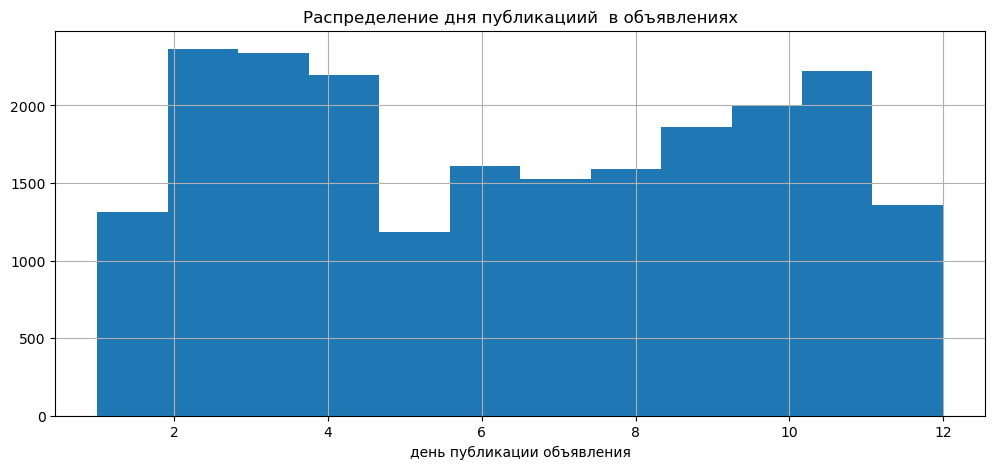

In [132]:
# день и месяц публикации объявления
df["month"].hist(figsize=(12,5), bins=12, range=(1, 12))
plt.xlabel('день публикации объявления')
plt.title('Распределение дня публикациий  в объявлениях')
plt.show() 

по графику видим что в осном публикуются в период понeдельник-четверг, а по месяцам просядают январь и май

### Шаг 4. Проведите исследовательский анализ данных:

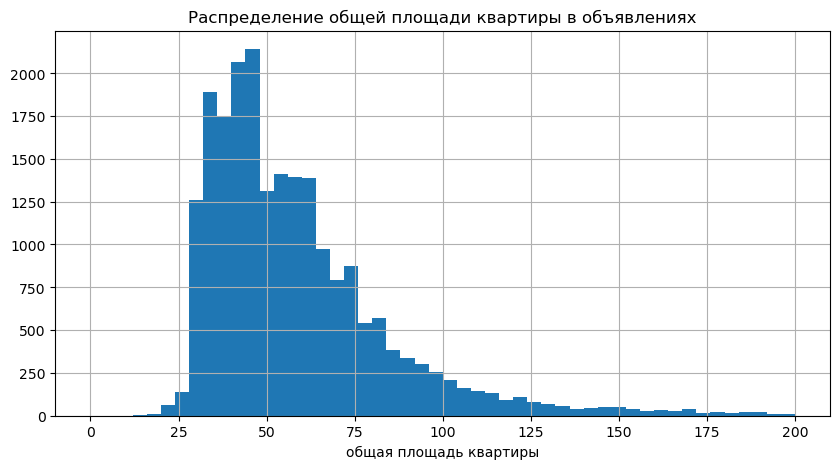

In [133]:
df["total_area"].hist(figsize=(10,5), bins=50, range=(0, 200))
plt.xlabel('общая площадь квартиры')
plt.title('Распределение общей площади квартиры в объявлениях')
plt.show() 

по графику видим что более 50 % данных в отметке до 50-60 м2, затем идет плавное снижение

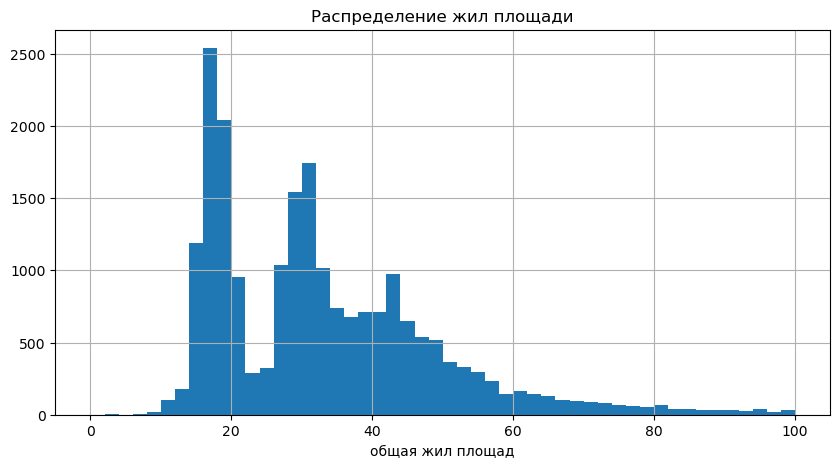

In [134]:
df["living_area"].hist(figsize=(10,5), bins=50, range=(0, 100))
plt.xlabel('общая жил площад')
plt.title('Распределение жил площади')
plt.show() 

по графику видим что пик данных в 20 м2, после значения проваливаются около 25-30 м2, затем  восстанавливаются к отметке 1500 и идет спад

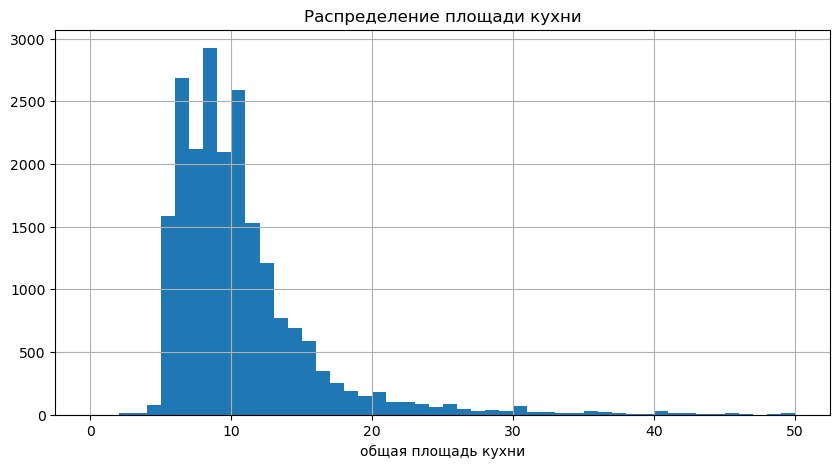

In [135]:
df["kitchen_area"].hist(figsize=(10,5), bins=50, range=(0, 50))
plt.xlabel('общая площадь кухни')
plt.title('Распределение площади кухни')
plt.show() 

по графику видим что пик данных в 10 м2, после идет спад

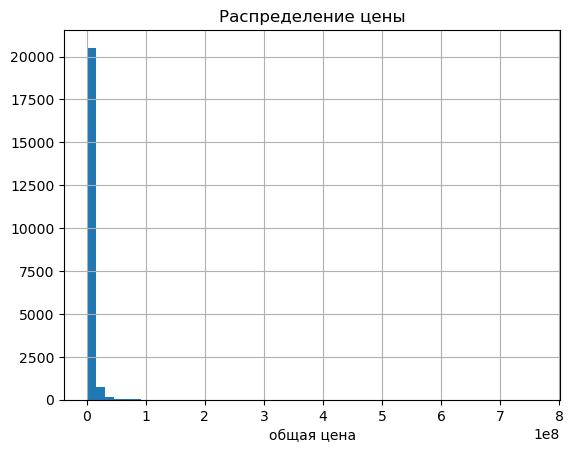

In [136]:
df["last_price"].hist(bins=50)
plt.xlabel('общая цена')
plt.title('Распределение цены')
plt.show()


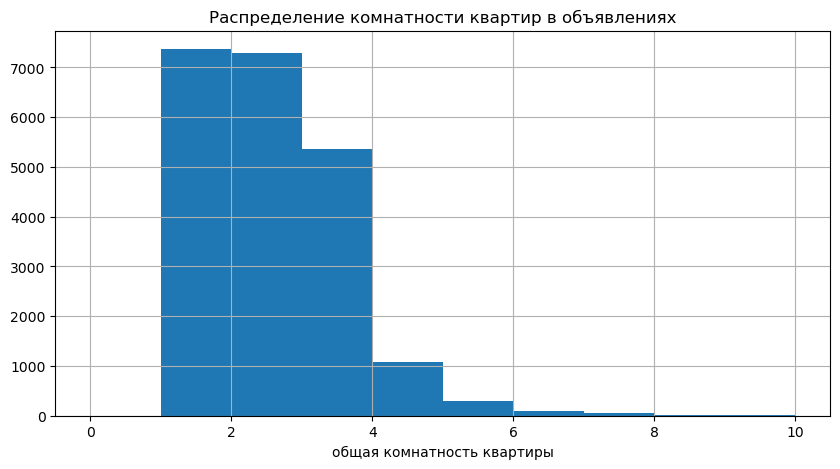

In [137]:
df["rooms"].hist(figsize=(10,5), bins=10, range=(0,10))
plt.xlabel('общая комнатность квартиры')
plt.title('Распределение комнатности квартир в объявлениях')
plt.show() 

на графике видим, что в основном в объявлених 2-3х комнатные квартиры

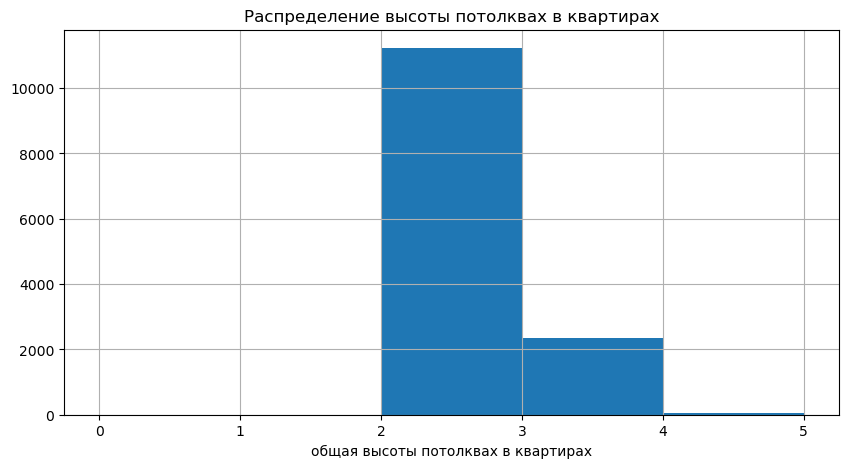

In [138]:
df["ceiling_height"].hist(figsize=(10,5), bins=5, range=(0,5))
plt.xlabel('общая высоты потолквах в квартирах')
plt.title('Распределение высоты потолквах в квартирах')
plt.show() 

на графике видим, что в основном в объявлених потолки в предах 3м

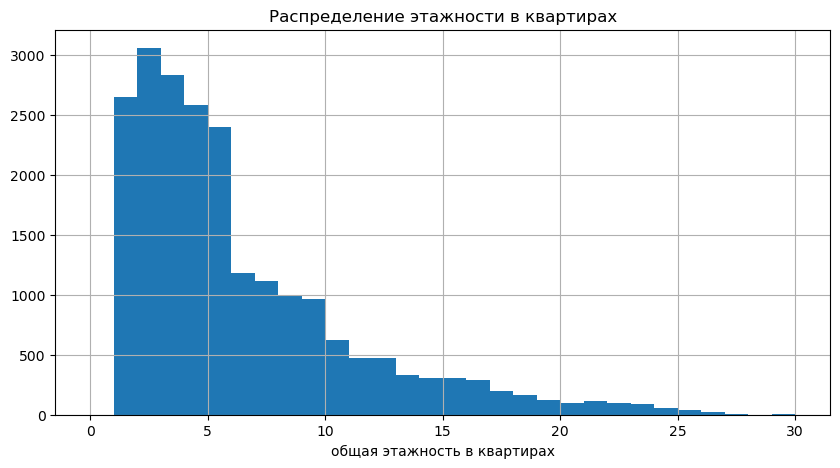

In [139]:
df["floor"].hist(figsize=(10,5), bins=30, range=(0,30))
plt.xlabel('общая этажность в квартирах')
plt.title('Распределение этажности в квартирах')
plt.show() 

на графике видим, что в основном в объявлених квартиры в предалаз 5 этажей

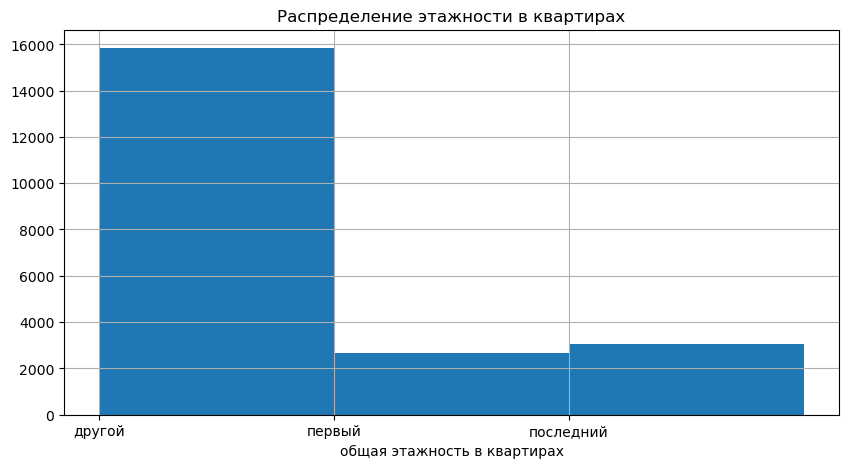

In [140]:
df["floortype"].hist(figsize=(10,5), bins=3, range=(0,3))
plt.xlabel('общая этажность в квартирах')
plt.title('Распределение этажности в квартирах')
plt.show() 

как видим по графику, в основном в продаже квартиры тип этажности "Другие"

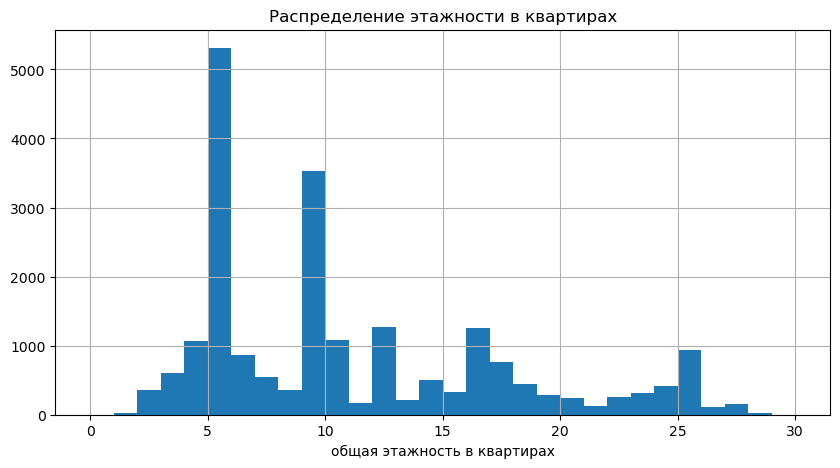

In [141]:
df["floors_total"].hist(figsize=(10,5), bins=30, range=(0,30))
plt.xlabel('общая этажность в квартирах')
plt.title('Распределение этажности в квартирах')
plt.show() 

по графику видим пики в 5 и 10 этажей

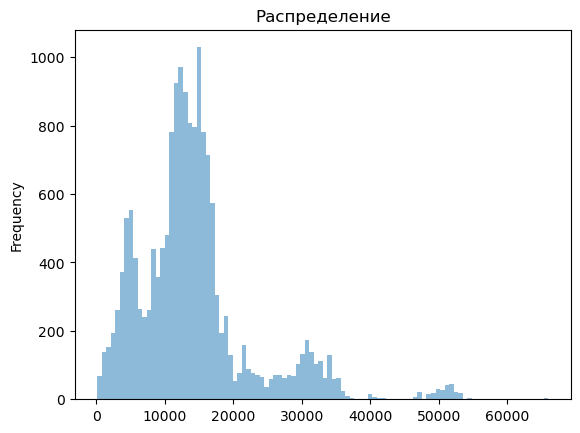

In [142]:
# постороение гистограммы распред. 
df['cityCenters_nearest'].plot(kind='hist', bins=100, alpha=0.5,title='Распределение')
plt.show()

по графику видим что более 50% расположено в районе до 2км, затем следует резкий спад

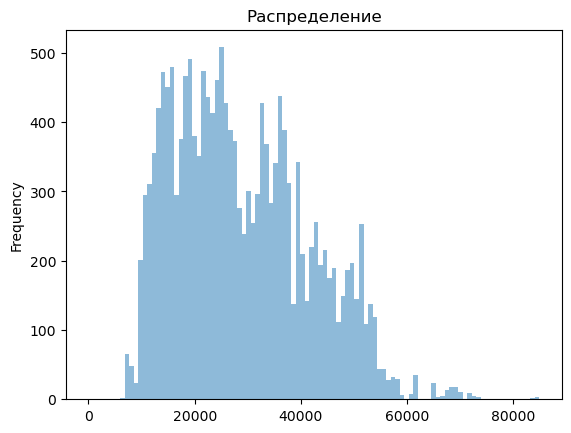

In [143]:
# постороение гистограммы распред. 
df['airports_nearest'].plot(kind='hist', bins=100, alpha=0.5,title='Распределение')
plt.show()

In [144]:
df["airports_nearest"].isna().sum()

4840

в столбце более 65% пропусков, a по графику видим что более 90% расположено в районе до 6км

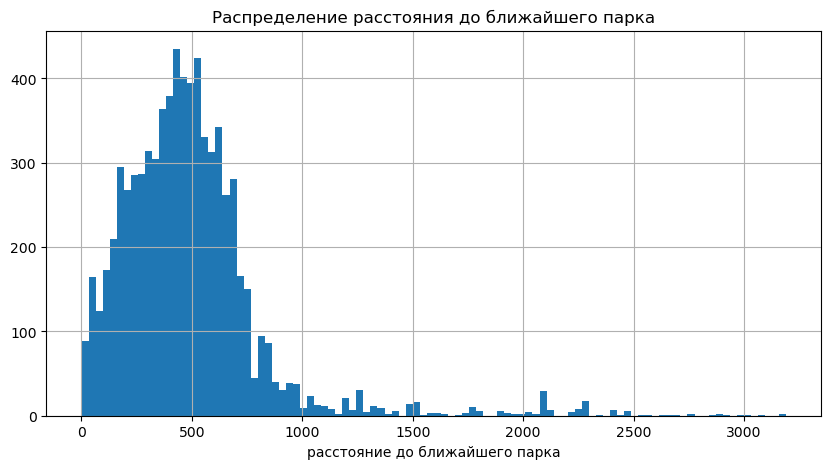

In [145]:
# постороение гистограммы распред. 
df["parks_nearest"].hist(figsize=(10,5), bins=100)
plt.xlabel('расстояние до ближайшего парка')
plt.title('Распределение расстояния до ближайшего парка')
plt.show() 

In [146]:
df["parks_nearest"].isna().sum()

14105

в столбце более 65% пропусков, а по графику видим что более 90% расположены в районе до 1км

### 4.2
- Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление. 

In [147]:
investigate_column(df["days_exposition"])

Null or Na count is 2965
count    18595.000000
mean       185.576230
std        221.684889
min          1.000000
25%         45.000000
50%        102.000000
75%        240.000000
max       1580.000000
Name: days_exposition, dtype: float64


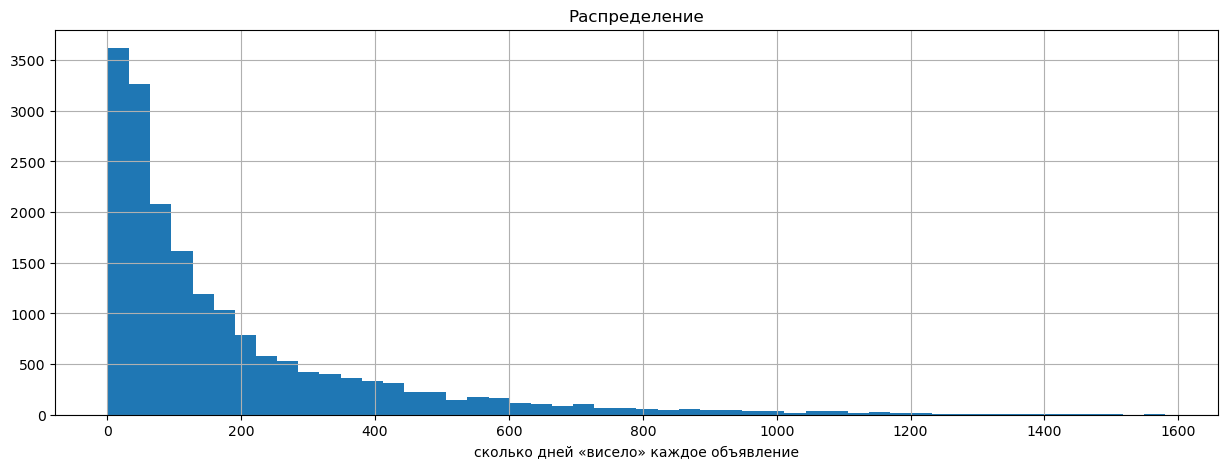

In [148]:
# постороение гистограммы распред. 
df["days_exposition"].hist(figsize=(15,5), bins=50)
plt.xlabel('сколько дней «висело» каждое объявление')
plt.title('Распределение')
plt.show() 

по графику видим что в основном продаются за 100 - 200 дней, затем идет плавное снижение

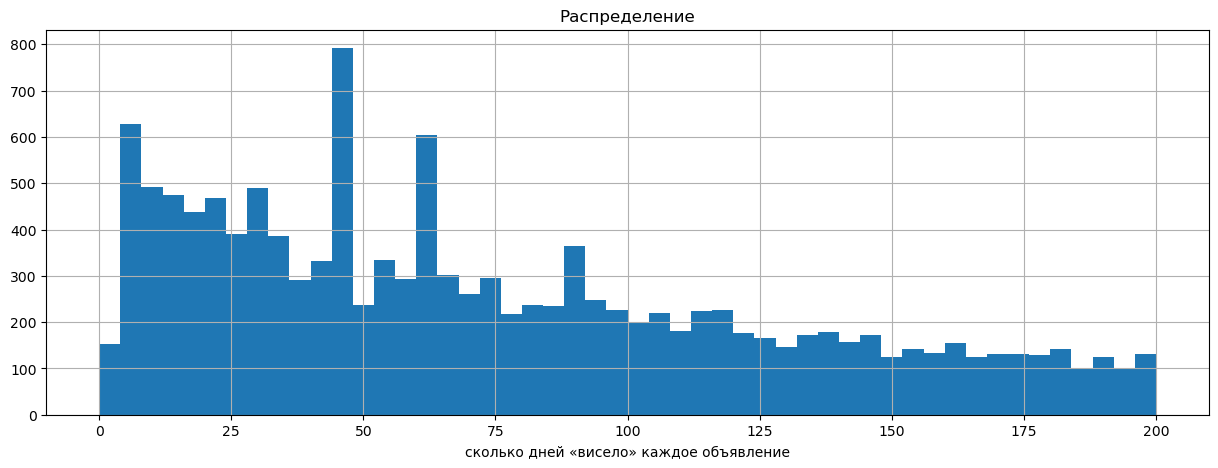

In [149]:
# в диапазоне 0, 200 
df["days_exposition"].hist(figsize=(15,5), bins=50, range=(0, 200))
plt.xlabel('сколько дней «висело» каждое объявление')
plt.title('Распределение')
plt.show() 

в диапазоне 200 дней можно наблюдать пики в 45, 60 и 80 дней

In [150]:
#расчитываем медиану
df["days_exposition"].median()

102.0

In [151]:
# медиана по Питеру
df.query('locality_name == "Санкт-Петербург"')["days_exposition"].median()

99.0

In [152]:
# среднее по Питеру
df.query('locality_name == "Санкт-Петербург"')["days_exposition"].mean()

185.5326609029779

In [153]:
#расчитываем среднее
df["days_exposition"].mean()

185.5762301694004

In [154]:
(df["days_exposition"] <=3).sum()

3

In [155]:
(df["days_exposition"] <=4).sum()

320

как видим особо быстрый продажей можно считать в течение 3 дня, всего таких сделок было 4

In [156]:
(df["days_exposition"] >= 1000).sum()

254

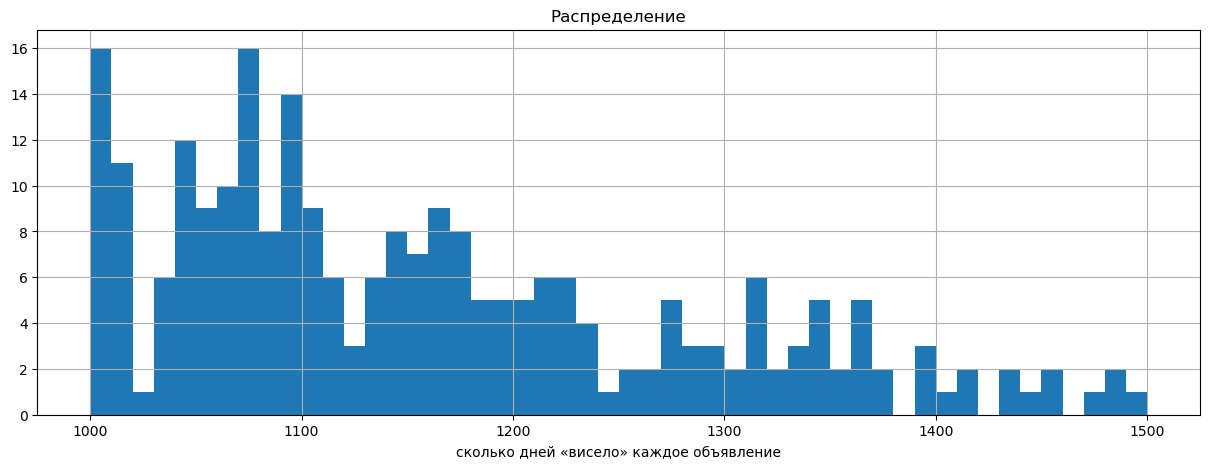

In [157]:
# в диапазоне 1000, 1500 
df["days_exposition"].hist(figsize=(15,5), bins=50, range=(1000, 1500))
plt.xlabel('сколько дней «висело» каждое объявление')
plt.title('Распределение')
plt.show() 

In [158]:
(df["days_exposition"] >= 1200).sum()

85

как видим по графику, к особо долгим можно отнести после 1200 дней

Вывод по шагу 4.2
- по графику видим что в основном продаются за 100 - 200 дней, затем идет плавное снижение
- в диапазоне 200 дней можно наблюдать пики в 45, 60 и 90 дней
- медиана 102 и среднее 185, отдельно по СПБ не сильно отличается 99 и 185 соответственно
- к необычно быстрым можно считать продажу до 3х дней, таких всего 3, а до 4 дней 320. Разница одного дня!
- к необычно долгим можно считать продажу свыше 1200 дней, таких всего 85.


In [159]:
# создание сводных таблиц ля каждого параметра
price_vs_area = df.pivot_table(index='total_area', values='last_price', aggfunc='median')
price_vs_living_area = df.pivot_table(index='living_area', values='last_price', aggfunc='median')
price_vs_kitchen_area = df.pivot_table(index='kitchen_area', values='last_price', aggfunc='median')
price_vs_rooms = df.pivot_table(index='rooms', values='last_price', aggfunc='median')
price_vs_floortype = df.pivot_table(index='floortype', values='last_price', aggfunc='median')
price_vs_weekday = df.pivot_table(index='weekday', values='last_price', aggfunc='median')
price_vs_month = df.pivot_table(index='month', values='last_price', aggfunc='median')
price_vs_year = df.pivot_table(index='year', values='last_price', aggfunc='median')

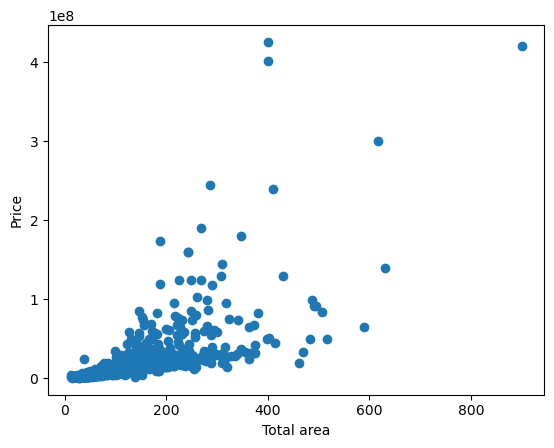

In [160]:
plt.scatter(price_vs_area.index, price_vs_area['last_price'])
plt.xlabel('Total area')
plt.ylabel('Price')
plt.show()

видим равномерный рост и на 300-400 разброс

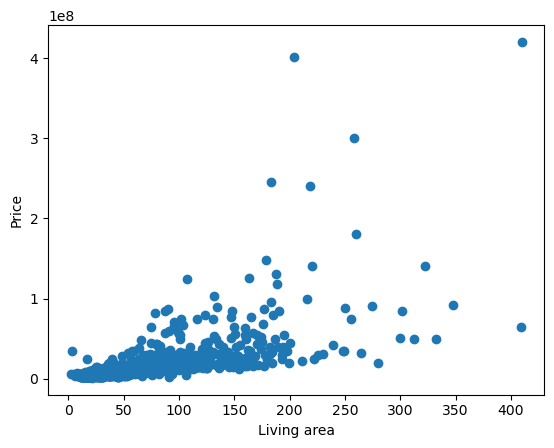

In [161]:
plt.scatter(price_vs_living_area.index, price_vs_living_area['last_price'])
plt.xlabel('Living area')
plt.ylabel('Price')
plt.show()

тоже самое только на 200м2

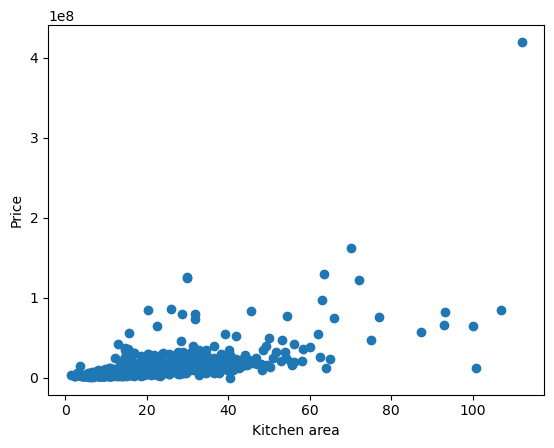

In [162]:
plt.scatter(price_vs_kitchen_area.index, price_vs_kitchen_area['last_price'])
plt.xlabel('Kitchen area')
plt.ylabel('Price')
plt.show()

то же самое только на 60, и аномальное значение свыше 100

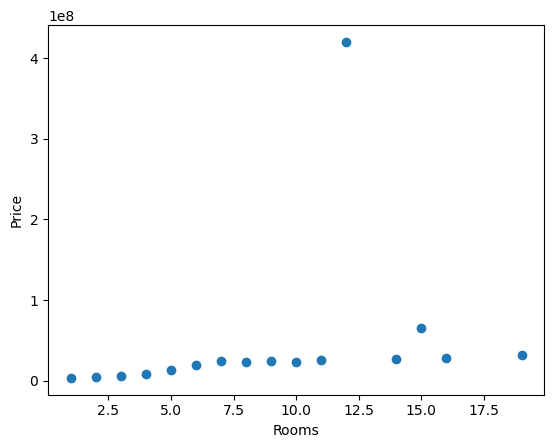

In [163]:
plt.scatter(price_vs_rooms.index, price_vs_rooms['last_price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

плавный рост и аномальное значение на 12

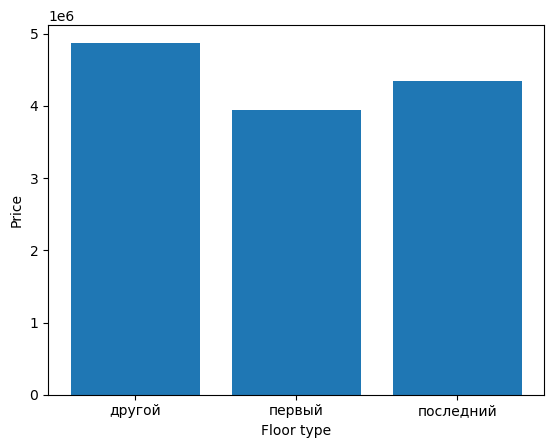

In [164]:
plt.bar(price_vs_floortype.index, price_vs_floortype['last_price'])
plt.xlabel('Floor type')
plt.ylabel('Price')
plt.show()

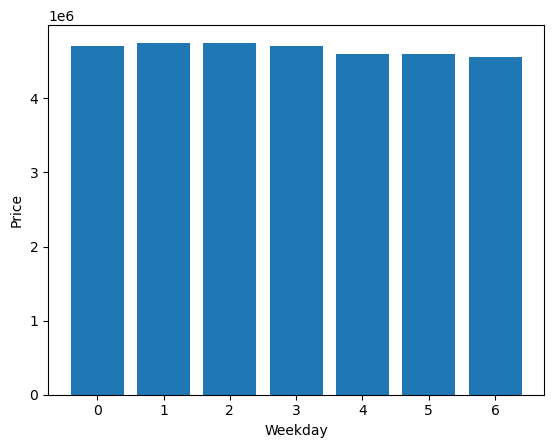

In [165]:
plt.bar(price_vs_weekday.index, price_vs_weekday['last_price'])
plt.xlabel('Weekday')
plt.ylabel('Price')
plt.show()

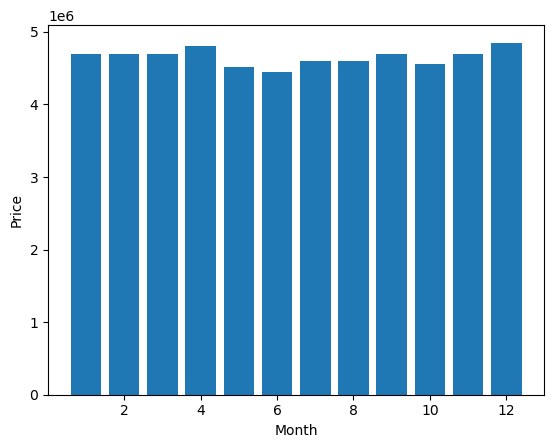

In [166]:
plt.bar(price_vs_month.index, price_vs_month['last_price'])
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

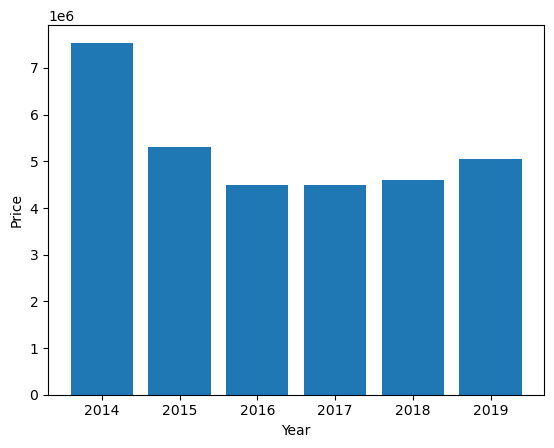

In [167]:
plt.bar(price_vs_year.index, price_vs_year['last_price'])
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

по графиками видим, что:
- чем больше площадь, тем больше и цена, но на отметке 300-400 м2 наблюдаем разброс, цена может быть как выше так и ниже
- в жил. площади все то же самое, только на отметке 200 м2
- площадь кухни все то же самое, только на отметке 60 м2, чем больше кухня, тем дороже(аномалия где кухня больше 100 м2)
- число комнат, плавный рост и аномальноме значение 12
- по остальным все ровно, кроме цены в годах, в 2014 году была максимальная цена
- возможно есть какая-то связь между аномальными значениями 12 комнат, кухни больше 100м2, мб продается мега крутой особняк ?


In [168]:
df_corr = df[['last_price', 'total_area','living_area', 'kitchen_area', 'rooms', 'year', 'month', 'weekday', 'floortype']]
df_corr.corr()

C:\Users\User\AppData\Local\Temp\ipykernel_7564\324048686.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr.corr()


,last_price,total_area,living_area,kitchen_area,rooms,year,month,weekday
last_price,1.000000,0.641517,0.565929,0.517690,0.361719,-0.038840,0.002204,-0.000323
total_area,0.641517,1.000000,0.939694,0.609457,0.773572,-0.080291,0.005123,-0.006812
living_area,0.565929,0.939694,1.000000,0.428768,0.849947,-0.071511,-0.001177,-0.005816
kitchen_area,0.517690,0.609457,0.428768,1.000000,0.269760,-0.058788,0.003130,-0.009674
rooms,0.361719,0.773572,0.849947,0.269760,1.000000,-0.052504,-0.002855,-0.002928
year,-0.038840,-0.080291,-0.071511,-0.058788,-0.052504,1.000000,-0.255192,-0.007746
month,0.002204,0.005123,-0.001177,0.003130,-0.002855,-0.255192,1.000000,0.009947
weekday,-0.000323,-0.006812,-0.005816,-0.009674,-0.002928,-0.007746,0.009947,1.000000


C:\Users\User\AppData\Local\Temp\ipykernel_7564\1797737670.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')


<Axes: >

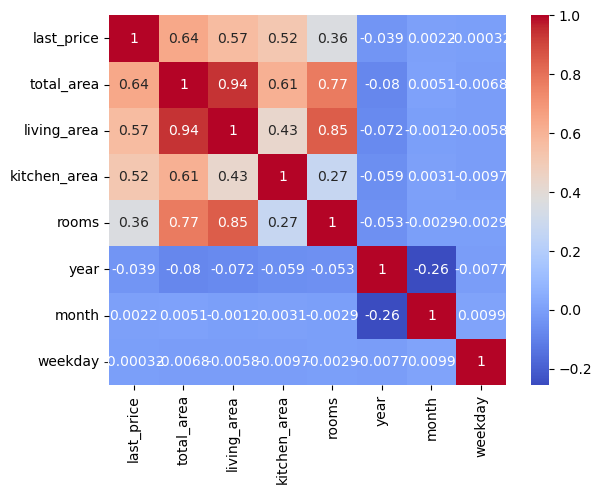

In [169]:
#Создание тепловой карты с помощью seaborn
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')

как видим по тепловой карте больше всего на цену влияет общ. площадь, жил.площадь и площадь кухни

##### выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`.

In [170]:
#Сначала узнаем топ 10 нас. пунктов с обявлениями
top_10 = df['locality_name'].value_counts().head(10).index.tolist()
top_10

['Санкт-Петербург',
 'Мурино',
 'Кудрово',
 'Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'Парголово',
 'Гатчина',
 'Петергоф']

In [171]:
#создаем отдельный дф с топ 10
top_10_df = df[df['locality_name'].isin(top_10)]

In [172]:
#расчитываем среднее цену за м2
mean_price_per_sqm = top_10_df.groupby('locality_name')['price_per_sqm'].mean().sort_values(ascending=False)
mean_price_per_sqm

locality_name
Санкт-Петербург    114170.886751
Пушкин             103428.482899
Кудрово             95467.677057
Парголово           90570.013131
Мурино              86082.736345
Петергоф            84480.969036
Шушары              78442.417000
Колпино             75344.099390
Всеволожск          68873.631421
Гатчина             68627.364384
Name: price_per_sqm, dtype: float64

In [173]:
df.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,14431,5500000.0
Мурино,498,3492500.0
Кудрово,401,3900000.0
Шушары,400,3950000.0
Всеволожск,366,3500000.0
Пушкин,345,5200000.0
Колпино,328,3600000.0
Парголово,297,4100000.0
Гатчина,292,3095000.0


In [174]:
# рассчитываем пункты с самой высокой и низкой стоимостью квадратного метра
locality_with_highest_price = mean_price_per_sqm.idxmax()
locality_with_lowest_price = mean_price_per_sqm.idxmin()

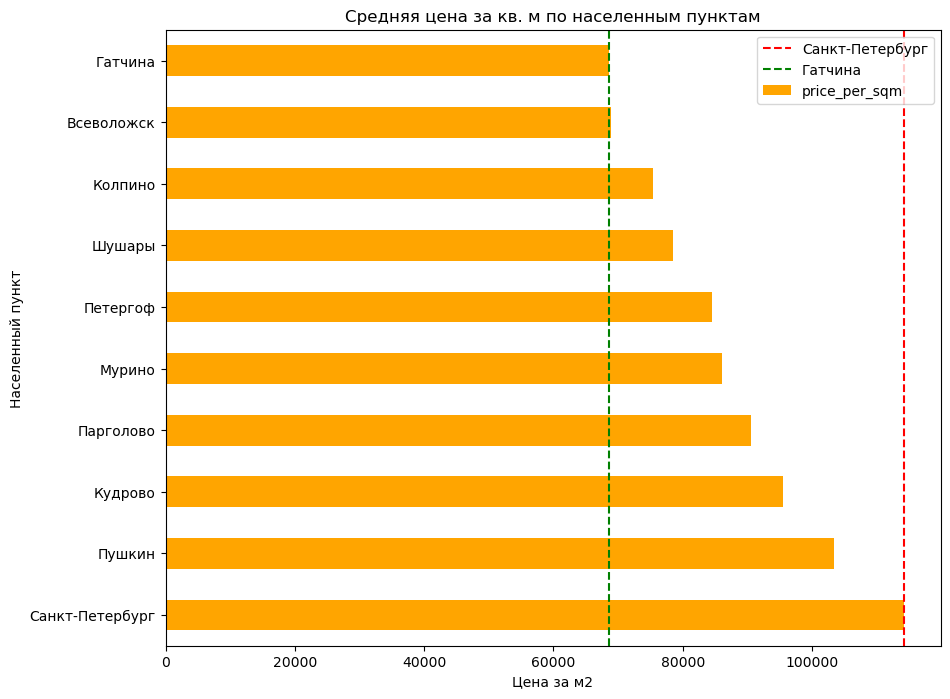

In [175]:
# создаем гистограмму
ax = mean_price_per_sqm.plot.barh(figsize=(10, 8), color='orange')

# добавляем название и описание таблицы
ax.set_xlabel('Цена за м2')
ax.set_ylabel('Населенный пункт')
ax.set_title('Средняя цена за кв. м по населенным пунктам')

# добавляем вертикальные линии
ax.axvline(x=mean_price_per_sqm[locality_with_highest_price], color='red', linestyle='--', label=locality_with_highest_price)
ax.axvline(x=mean_price_per_sqm[locality_with_lowest_price], color='green', linestyle='--', label=locality_with_lowest_price)

# добавляем описание
ax.legend()

# выводим график
plt.show()


по графику видим что самая высокая средняя цена в "Санкт-Петербург", а самая низкая в "Гатчина", разница почти в 1,5 раза

##### выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."

In [176]:
#создаем отдельный датасет для квартир в Санкт-Петербурге 
spb_data = df[df['locality_name'] == 'Санкт-Петербург']

In [177]:
#группируем данные по расстоянию и высчитываем среднию цену за м2
price_by_distance = spb_data.groupby('cityCenters_nearest_km')['price_per_sqm'].mean()

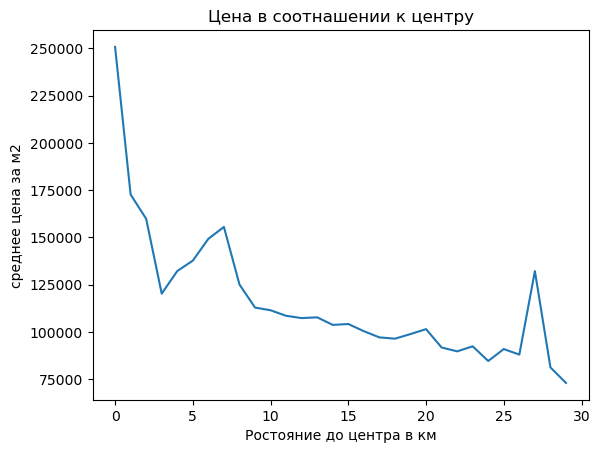

In [178]:
# выводим график
plt.plot(price_by_distance.index, price_by_distance.values)
plt.title('Цена в соотнашении к центру')
plt.xlabel('Ростояние до центра в км')
plt.ylabel('среднее цена за м2')

plt.show()

по графику видим пиковые значения до 3 км, тоесть чем ближе тем дороже (до 250к за м2). Затем после 3 км до 7 км идет плавный рост с 125к до 150к, и плавное снижение. Так же есть выброс в районе 28 км.

## Общий вывод:

Данные были получены, по каждому столбцу предобработал данные, заполнил пропуска там где посчитал нужным, удалил дубликаты. Особенно можно отметить столбец высота потолков, выделился аномальными значениями до 100м, пришлось подкорректировать данные. Далее по имеющимся данным добавил новые столбцы такие как цена за м2, день недели, месяц, год публикации, тип этажа и растояние до центра в км. Затем провел исследовательский анализ данных, тоесть изучил какие параметры больше всего влияют на стоимость недвижки. Общая жил площадь конечно влияет на стоимоисть квартиры, но только до 400м2, затем идет разброс данных. На цену в основном влияют такие факторы как общая площадь, жил. площадь, площадь кухни и количества комнат. "Санкт-Петербург", что не удивительно является самым дорогим нас. пунктом по цене за м2, а "Гатчино" самым низким, разница почти в 1,5 раза. В центре питера самые высокие значения в отметке от 1 до 3км (до 250к рублей). - к необычно быстрым можно считать продажу до 3х дней, а
к необычно долгим можно считать продажу свыше 1200 дней, таких всего 85.